In [1]:
from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

import datetime

In [2]:
class WebScrapingToDF(object):
    def __init__(self, url):
        self._url = url
    
    def start(self, table_class="sortable wikitable"):
        """
            1. make initial request
            2. turn the request into soup object
            3. get table
            4. from table get columns and rows
            5. return pandas dataframe of data obtained
        """
        url_html = self._make_request()
        soup = BS(url_html, 'html.parser')
        
        table = WebScrapingToDF._get_table(soup, table_class=table_class)
        
        columns = WebScrapingToDF._get_headers(table)
        rows = WebScrapingToDF._get_rows(table)
        
        return pd.DataFrame(data=rows, columns=columns)
    
    def _make_request(self):
        request = urllib.request.Request(self._url)
        result = urllib.request.urlopen(request)
        return result.read()
    
    @staticmethod
    def _get_table(soup, table_class):
        table_html = soup.find_all('table', class_=table_class)
        return table_html[0]
    
    @staticmethod
    def _get_headers(table):
        table_headers = table.find_all("th")
        return [th.text for th in table_headers]
    
    @staticmethod
    def _get_rows(table):
        rows = []
        for tr in table.find_all("tr")[1:]:
            row_data = [td.text for td in tr.find_all("td")]
            rows.append(row_data)
            
        return rows
    

# We are using data from multiple resources. Here is all the links we used to gather this info!!! Results are all dataframes :D 

In [3]:
# Gather earthquakes info
earthquakes_scraping = WebScrapingToDF(url="https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900")
earthquakes = earthquakes_scraping.start()

In [4]:
# Gather volcano info
volcanoes_scraping = WebScrapingToDF(url="http://volcano.oregonstate.edu/volcano_table")
volcanoes = volcanoes_scraping.start(table_class="views-table cols-6")

In [5]:
# Gather vents info
vents_scraping = WebScrapingToDF(url="http://vents-data.interridge.org/ventfields_list_all")
vents = vents_scraping.start(table_class="views-table cols-8")

In [6]:
class CleanData(object):
    def __init__(self, df):
        self._df = df
        
    def clean_col_by_regex(self, regex, column):
        self._df[column] = self._df[column].str.replace(regex, "")
        
    def nan_to_float32(self, columns, value=0, inplace=True):    
        for col in columns:        
            self._df[col].fillna(value=value, inplace=inplace)
            self._df[col] = pd.to_numeric(self._df[col], downcast='float')
            
    def strip_columns(self, columns):
        for column in columns:
            self._df[column] = self._df[column].str.strip()      

## Cleaning the Earthquake Data

In [7]:
class CleanEarthquakes(CleanData):
    def __init__(self, df):
        super(CleanEarthquakes, self).__init__(df)
        
    def clean_cols_by_extract(self, columns, regex):
        for col in columns:
            self._df[col] = self._df[col].str.extract(regex, expand=True)
        
    def convert_nan_lat_lng(self, is_nan):
        """There are son lat/lng values in the dataframe that didn't exist on the wiki page, so we looked up the coords
            and assigned them to their appropriate location

            First index is LNG, second is LAT
        """
        for loc, coords in is_nan.items():
            self._df.iloc[loc, self._df.columns.get_loc('lng')] = coords[0]
            self._df.iloc[loc, self._df.columns.get_loc('lat')] = coords[1]

        assert self._df[self._df["lat"].isnull()].empty == True
        assert self._df[self._df["lng"].isnull()].empty == True
        
    def convert_values_in_row_by_index(self, index, **kwargs):
        """There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
        for key, value in kwargs.items():
            self._df.iloc[index, self._df.columns.get_loc(key)] = value    
            
    def get_mean_deaths(self, column):
        """There can potentially be multiple values within the Other Source Deaths column. So, this is grabbing the 
            values and determining the mean
        """
        means = []
        for row in self._df[column]:
            if isinstance(row, str):
                int_list = row.strip().split(" ")
                total = 0
                total = sum(list(map(int, map(float, int_list))))

                mean = total / len(int_list)
                means.append(mean)
            else:
                means.append(row)

        self._df[column] = means

In [8]:
# rename columns
earthquakes.columns = ["UTC", "Country", "lat", "lng", "Depth_km", "Mag", "Secondary_Effects", "PDE_Shaking_Deaths", "PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]

In [9]:
clean_earthquakes = CleanEarthquakes(earthquakes)

clean_earthquakes.clean_col_by_regex(regex=r"(\[\d+\]|\(.*\)|\*|\+|\,)", column="Other_Deaths")
clean_earthquakes.clean_col_by_regex("(\s\(.*)", column="Country")

is_nan = {439: [69.13, 41.16], 1319: [90.302, 29.759], 1320: [67.484, 30.569], 1323: [101.086, 25.619], 1324: [138.276, 34.778], 1325: [107.328, -7.778], 1326: [-171.87, -15.53], 1327: [99.97, 0.71], 1330: [40.03, 38.79], 1331: [-72.13, -34.301], 1332: [96.629, 33.165], 1333: [172.7012, -43.5834], 1334: [97.994, 24.71], 1336: [99.949, 20.705]}
clean_earthquakes.convert_nan_lat_lng(is_nan)

"""There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
question_index = earthquakes[earthquakes["lat"] == "?"].index
clean_earthquakes.convert_values_in_row_by_index(question_index, lat=21.4, lng=42.1, Depth_km=6)

"""There are some bad characters in this column, so this regex just grabs the int"""
clean_earthquakes.clean_cols_by_extract(columns=['EM-DAT_Deaths', 'Mag'], regex='(\d+\.\d*)')

"""Transforms the column in the dataframe to a float32 column, rather than the object type. 
    Also fills all NaN values to 0.
"""
columns_to_convert = ['PDE_Deaths', 'PDE_Shaking_Deaths', 'Utsu_Deaths', 'EM-DAT_Deaths', 'Mag', 'lat', 'lng', 'Depth_km']
clean_earthquakes.nan_to_float32(columns=columns_to_convert)

In [10]:
# Create the apropriate datetime columns with padding for javascript visuals
earthquakes["UTC"] = pd.to_datetime(earthquakes["UTC"])
earthquakes["Year"] = pd.DatetimeIndex(earthquakes["UTC"]).year
earthquakes["Month"] = pd.DatetimeIndex(earthquakes["UTC"]).month.map("{:02}".format)
earthquakes["Day"] = pd.DatetimeIndex(earthquakes["UTC"]).day.map("{:02}".format)

In [11]:
# Creating a new column 'deaths' that is the max of these four columns
subdf = earthquakes[["PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]]
earthquakes["Max_Deaths"] = subdf.max(axis = 1)

[Text(0,0,'China'),
 Text(0,0,'Indonesia'),
 Text(0,0,'Turkey'),
 Text(0,0,'Iran'),
 Text(0,0,'Japan'),
 Text(0,0,'Peru'),
 Text(0,0,'Taiwan'),
 Text(0,0,'Mexico'),
 Text(0,0,'Chile'),
 Text(0,0,'Greece'),
 Text(0,0,'Philippines'),
 Text(0,0,'Italy'),
 Text(0,0,'United States'),
 Text(0,0,'Afghanistan'),
 Text(0,0,'Pakistan'),
 Text(0,0,'India'),
 Text(0,0,'Colombia'),
 Text(0,0,'Algeria'),
 Text(0,0,'Ecuador'),
 Text(0,0,'Papua New Guinea'),
 Text(0,0,'Guatemala'),
 Text(0,0,'South Africa'),
 Text(0,0,'Russian Federation'),
 Text(0,0,'Argentina'),
 Text(0,0,'Burma')]

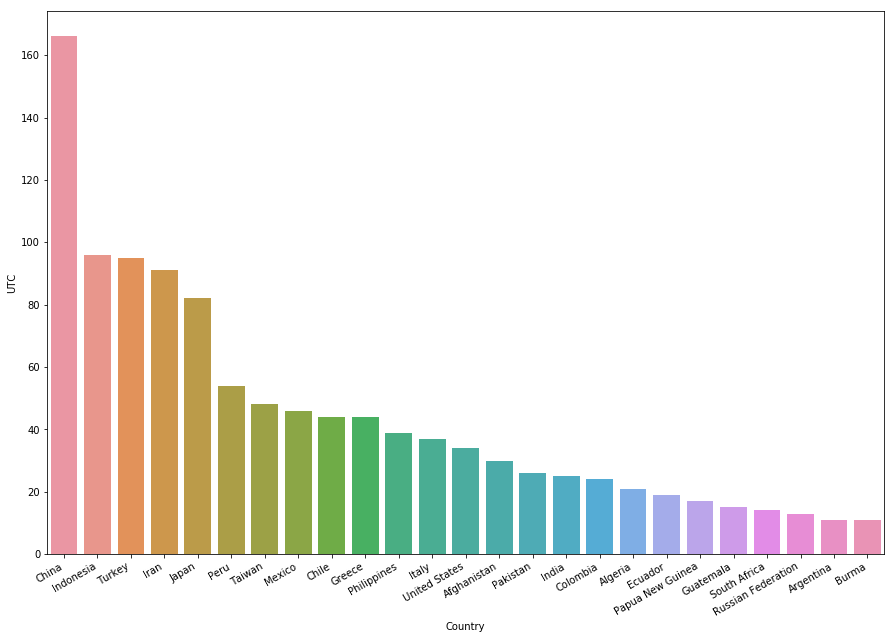

In [12]:
quakes_country_25 = earthquakes.groupby("Country").agg(len).reset_index().nlargest(25, columns="UTC")

f, ax = plt.subplots(figsize=(15, 10))
#plt.ylabel('Number of Quakes')
quake_count = sns.barplot(x='Country', y='UTC', data=quakes_country_25)
quake_count.set_xticklabels(quake_count.get_xticklabels(), rotation=30, ha="right")

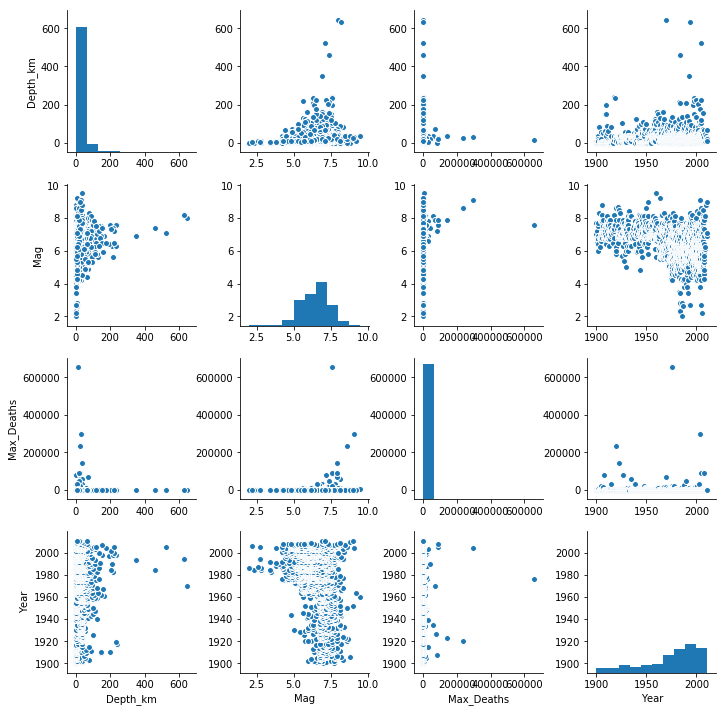

In [13]:
"""Trying to find any correlation between these columns. Most interesting find is between Depth and Mag"""
earthquakes_cont = earthquakes[["Depth_km", "Mag", "Max_Deaths", "Year"]]
earthquakes_cont = earthquakes_cont.replace("?", np.nan)
earthquakes_cont = earthquakes_cont.dropna()

sns.pairplot(earthquakes_cont, dropna=True)

In [14]:
# Total deaths by country
occurrence_death = earthquakes[['Country', 'Max_Deaths']].groupby(['Country']).agg(['sum', 'count'])
occurrence_death.columns=['Total Deaths', 'Frequency of Earthquakes']

EQ_Casualities = occurrence_death.sort_values(['Frequency of Earthquakes'], ascending=False)
EQ_Casualities.head()

,Total Deaths,Frequency of Earthquakes
Country,,
China,1138388.0,166
Indonesia,342112.0,96
Turkey,90836.0,95
Iran,152664.0,91
Japan,166997.0,82


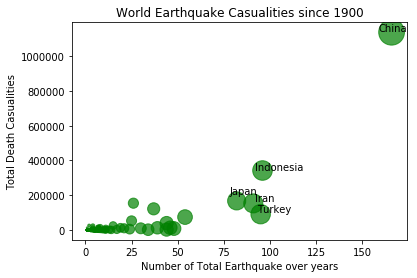

In [15]:
# Base size of dots based on frequency
np_death = np.array(EQ_Casualities['Frequency of Earthquakes'])
np_death = np_death*4

# Find correlation between Frequency and Total Deaths
plt.scatter(EQ_Casualities['Frequency of Earthquakes'], EQ_Casualities['Total Deaths'], s=np_death, color='green', alpha=0.7)

# Hard code some labels
plt.text(159, 1143382.0, 'China')
plt.text(93, 103304.0, 'Turkey')
plt.text(92, 167960.0, 'Iran')
plt.text(92, 343574.0, 'Indonesia')
plt.text(78, 205148.0, 'Japan')

plt.xlabel('Number of Total Earthquake over years')
plt.ylabel('Total Death Casualities')

plt.title('World Earthquake Casualities since 1900')

plt.show()

In [16]:
earthquakes.drop("UTC", inplace=True, axis=1)
earthquakes.to_json("JSONs_for_TP/earthquakes_original.json")

## Cleaning the Volcano Data

In [17]:
class CleanVolcanoes(CleanData):
    def __init__(self, df):
        super(CleanVolcanoes, self).__init__(df)
        
    def replace_all_rows_by_regex(self, regex):
        self._df.replace(to_replace=regex, value="", regex=True, inplace=True)     

In [18]:
volcanoes.columns = ["Name", "Country", "Type", "lat", "lng", "Elevation"]

In [19]:
clean_volcanos = CleanVolcanoes(volcanoes)

# Replacing new lines and spaces with empty strings
clean_volcanos.replace_all_rows_by_regex(regex="(\n|\n\s)")

# remove extra whitespace from these columns
clean_volcanos.strip_columns(columns=['lat', 'lng', 'Elevation'])

# Convert lat and lng vals to numeric
columns_to_convert = ['lat', 'lng', 'Elevation']
clean_volcanos.nan_to_float32(columns=columns_to_convert)


## Cleaning the Vents Data

In [20]:
class CleanVents(CleanData):
    def __init__(self, df):
        super(CleanVents, self).__init__(df)
        

In [21]:
# Renaming columns
vents.columns = ["Name", "Activity", "Tectonic Setting", "Region", "lat", "lng", "Depth", "Year&Discovered"]

In [22]:
# Some basic cleaning of the rows
vents = vents.replace(to_replace="(\n|\n\s)", value="", regex=True)

clean_vents = CleanVents(df=vents)

# Strip extra whitespace from these columns
clean_vents.strip_columns(columns=['lat', 'lng', 'Year&Discovered', 'Depth'])

# Turn appropriate columns to numeric
clean_vents.nan_to_float32(["lat", "lng", "Depth"])

## Create GeoPandas DFs to Graph Later On

In [23]:
def create_gdf(df):
    geometry = [Point(xy) for xy in zip(df.lng, df.lat)]
        
    crs = {"init": "epsg:4326"} 
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [24]:
earthquakes_gdf = create_gdf(df=earthquakes)
volcanoes_gdf = create_gdf(df=volcanoes)
vents_gdf = create_gdf(df=vents)

In [25]:
# Import plates and countries geojson to plot
plates_gdf = gpd.read_file("MR_Data/PB2002_plates.json")
countries_gdf = gpd.read_file("MR_Data/countries.geojson")

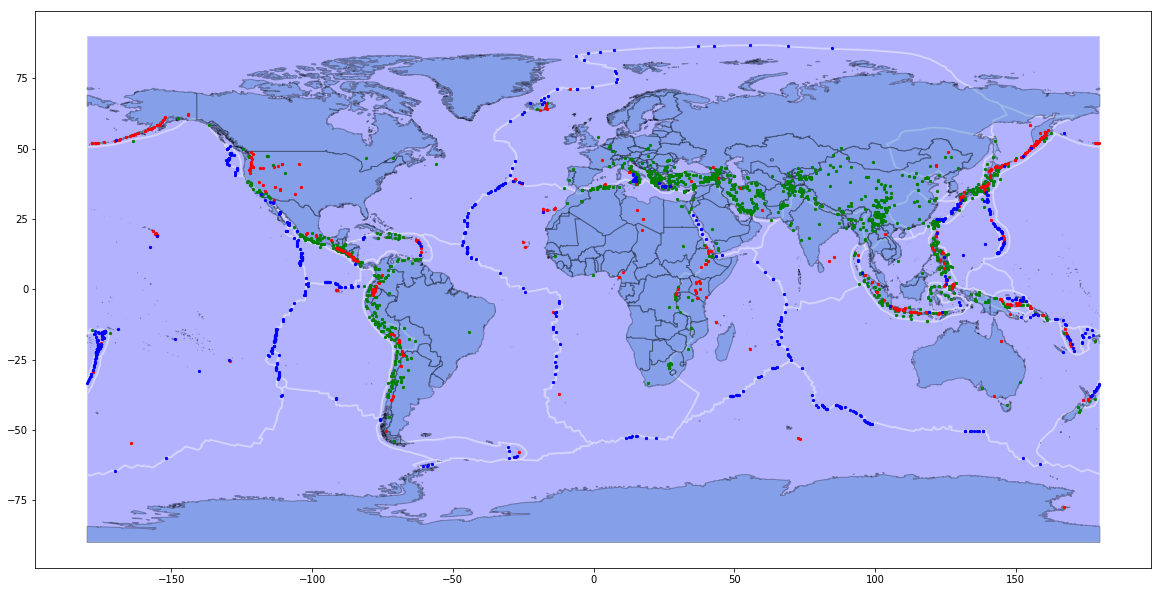

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha=0.3, lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
earthquakes_gdf.plot(ax=ax, markersize=5, color="green")
volcanoes_gdf.plot(ax=ax, markersize=5, color="red")
vents_gdf.plot(ax=ax, markersize=5, color="blue")

In [27]:
# Now that we have our data plotted out, we want to categorize the earthquakes based on location. 
# How close are they to the plates, and which plates are they closest to?
boundaries_gdf = gpd.read_file("MR_Data/PB2002_steps.json")

In [28]:
class ClosestPointLogic(object):
    def __init__(self, from_df, to_df, categories, extra_column_name):
        self._from_df = from_df
        self._to_df = to_df
        self._categories = categories
        self._extra_column_name = extra_column_name
    
    # We are wanting to grab the geometry columns per type of volcano
    def get_geometries_from_gdf(self, column):
        geometry_types = list()
        for df_type in self._categories:
            if df_type == 'None':
                df_type_geometry = self._to_df[self._to_df[column].str.contains("")].geometry
            else: 
                df_type_geometry = self._to_df[self._to_df[column].str.contains(df_type)].geometry

            geometry_types.append(df_type_geometry)
            
        # Add on the geometry from the overall df to compare against        
        geometry_types.extend([self._to_df.geometry]) 
        
        return geometry_types
    
    def calculate_nearest(self, to_column, dist_df):
        # Determine closest point based on category
        conditions = list()
        for col in self._categories:
            if not col == self._extra_column_name:
                dist_bool = (dist_df[self._extra_column_name] == dist_df[col])
                conditions.append(dist_bool)

        dist_df[to_column] = np.select(conditions, self._categories, default=np.nan)
        
        return dist_df
    
    def create_total_dist_df(self, series_geometry_list):
        total_dist_list = self._calculate_total_dist_list(series_geometry_list)
        
        dist_pd = pd.DataFrame(total_dist_list)
        dist_pd = dist_pd.transpose()

        dist_pd.columns = self._categories + [self._extra_column_name]

        return pd.concat([self._from_df, dist_pd], axis=1)
    
    def _calculate_total_dist_list(self, series_geometry_list):
        total_dist_list = []

        for geoseries in series_geometry_list:
            dist_list = self._quake_distance(geoseries)
            total_dist_list.append(dist_list)
            
        return total_dist_list
    
    def _quake_distance(self, geoseries):
        dist_list = []
        for quake in self._from_df.geometry:
            print(quake)
            dist = np.min([quake.distance(series) for series in geoseries if series])
            print(dist)
            dist_list.append(dist)

        return dist_list

In [29]:
vol_types = ["Stratovolcano", "Caldera", "Shield", "Complex Volcano", "Submarine", "Volcanic Field", "Cinder Cone", "Dome",
        "Fissure vents", "Somma Volcano", "Maar", "Pyroclastic Cone", "Tuff Ring", "Plug", "None"]

volcanoes_to_earthquake_logic = ClosestPointLogic(
    from_df=earthquakes_gdf,
    to_df=volcanoes_gdf,
    categories=vol_types,
    extra_column_name='vol'
)

In [30]:
vol_series_geometry_list = volcanoes_to_earthquake_logic.get_geometries_from_gdf(column='Type')

quake_vol_dist = volcanoes_to_earthquake_logic.create_total_dist_df(
    series_geometry_list=vol_series_geometry_list
)

quake_vol_dist = volcanoes_to_earthquake_logic.calculate_nearest(
    to_column='closest_vol',
    dist_df=quake_vol_dist
)

POINT (141.1000061035156 38.70000076293945)
1.10163363025
POINT (43.09999847412109 40.29999923706055)
1.3416407865
POINT (-66 11)
5.35362463221
POINT (100.0999984741211 26)
7.38312448136
POINT (28.70000076293945 43.40000152587891)
6.98195685493
POINT (142.5 40.5)
1.82187269177
POINT (173 -43)
3.86005428375
POINT (141.3000030517578 40.5)
0.763682013248
POINT (48.59999847412109 40.70000076293945)
4.41474726782
POINT (33.59999847412109 40.70000076293945)
7.63974393086
POINT (-91 14)
0.48507825162
POINT (129.6000061035156 43.20000076293945)
7.88156355242
POINT (77 40)
20.8086520467
POINT (138 -35)
27.9575550797
POINT (72.30000305175781 40.79999923706055)
17.751902871
POINT (35.29999923706055 32.20000076293945)
9.24833415835
POINT (42.65000152587891 39.13999938964844)
1.74243909076
POINT (42.70000076293945 40.90000152587891)
1.99999923706
POINT (22.96999931335449 36.36000061035156)
1.50880869981
POINT (58.20000076293945 35.20000076293945)
6.13600862601
POINT (120.5 23.5)
3.38541143917
POINT

10.4499970544
POINT (-77.62899780273438 -11.11900043487549)
7.42440217775
POINT (102.5 24.39999961853027)
5.01662238793
POINT (139.8289947509766 44.50799942016602)
2.21249685265
POINT (26.65500068664551 45.77299880981445)
9.19687384338
POINT (43.5 16.39999961853027)
3.27566761463
POINT (58.59999847412109 33.5)
5.67538582587
POINT (-102.9570007324219 18.67700004577637)
4.34620637504
POINT (127.1999969482422 47)
6.15588435274
POINT (99.40799713134766 23.51399993896484)
5.81145463555
POINT (92.47799682617188 12.14900016784668)
6.90854995992
POINT (43.29999923706055 39.5)
1.01980405234
POINT (102.3000030517578 31.70000076293945)
12.2612606291
POINT (39.40000152587891 39.70000076293945)
4.74124488933
POINT (132 32)
1.14214647295
POINT (120.390998840332 23.25099945068359)
3.21793931514
POINT (99.14499664306641 21.07600021362305)
4.74110067165
POINT (100.3000030517578 23.10000038146973)
4.88983630291
POINT (-79.90200042724609 0.01200000010430813)
1.36837540045
POINT (-90.91300201416016 13.779

7.40594494526
POINT (-62.71900177001953 10.73099994659424)
3.02048446277
POINT (-92.66000366210938 15.55099964141846)
1.36300455818
POINT (79.23899841308594 41.42599868774414)
23.4605306995
POINT (118.7990036010742 -3.178999900817871)
5.1335610214
POINT (-10.56799983978271 35.92300033569336)
9.76921622573
POINT (28.46699905395508 38.53499984741211)
2.34334605613
POINT (41.21900177001953 11.93900012969971)
1.19918470734
POINT (33.93600082397461 27.51099967956543)
11.3288321915
POINT (119.4530029296875 38.42100143432617)
5.79164978479
POINT (111.8089981079102 21.61199951171875)
8.45446899651
POINT (137.0930023193359 35.7859992980957)
0.659818704877
POINT (19.33600044250488 -33.18999862670898)
33.1854817872
POINT (-75.19499969482422 -11.83500003814697)
5.17223895027
POINT (-122.7639999389648 38.29999923706055)
3.16252698385
POINT (17.35300064086914 44.80699920654297)
6.38723101331
POINT (17.23399925231934 44.83700180053711)
6.37673839218
POINT (102.4619979858398 24.14699935913086)
4.77940

5.96230042138
POINT (-76.19000244140625 4.793000221252441)
0.875393460243
POINT (59.75400161743164 34.05599975585938)
6.06099399828
POINT (-79.36299896240234 1.603000044822693)
1.83422550854
POINT (102.5670013427734 -3.33899998664856)
0.849121286787
POINT (115.7529983520508 -8.487000465393066)
0.284000445189
POINT (-27.75099945068359 38.72600173950195)
0.366600854049
POINT (-121.7279968261719 37.71200180053711)
3.72674640178
POINT (16.15200042724609 39.29100036621094)
1.06694197717
POINT (-114.9079971313477 32.26800155639648)
11.6877600116
POINT (23.00799942016602 39.25699996948242)
2.93067775991
POINT (50.26200103759766 37.32199859619141)
2.30162561581
POINT (81.10299682617188 29.62299919128418)
18.6726035546
POINT (-88.48999786376953 15.91199970245361)
2.32403304237
POINT (-80.00199890136719 -1.986999988555908)
1.29416037337
POINT (75.69300079345703 32.92200088500977)
16.4467737449
POINT (75.7760009765625 32.89300155639648)
16.517374823
POINT (139.7400054931641 35.99700164794922)
0.7

2.25065575704
POINT (121.6790008544922 23.98600006103516)
3.53154684327
POINT (95.12599945068359 25.10499954223633)
10.1711410032
POINT (160.9329986572266 -10.31999969482422)
1.62937064803
POINT (51.58499908447266 29.94400024414062)
6.02890278857
POINT (51.65499877929688 29.88599967956543)
6.08104726223
POINT (86.61799621582031 26.76300048828125)
15.2969115611
POINT (18.48900032043457 49.88600158691406)
11.570353225
POINT (146.2259979248047 -6.061999797821045)
1.97473897498
POINT (-90.50099945068359 13.90799999237061)
0.610708236536
POINT (99.68099975585938 22.90900039672852)
5.20278259222
POINT (99.41100311279297 23.18600082397461)
5.58826075737
POINT (44.11800003051758 40.91899871826172)
1.2325095238
POINT (68.69899749755859 38.46099853515625)
13.6053315952
POINT (139.8600006103516 36.03799819946289)
0.815896983222
POINT (34.47299957275391 -13.68299961090088)
10.6785866025
POINT (152.8419952392578 -4.331999778747559)
1.67381261139
POINT (34.48500061035156 -13.70800018310547)
10.70046

8.79301251121
POINT (22.30900001525879 38.44400024414062)
2.7536698062
POINT (121.6790008544922 24.6200008392334)
4.16318081679
POINT (99.10299682617188 21.94799995422363)
5.13295091987
POINT (103.1660003662109 36.43600082397461)
16.9320883032
POINT (-70.25299835205078 -23.34000015258789)
2.52317335643
POINT (-98.60800170898438 16.84900093078613)
2.17103269691
POINT (30.14299964904785 38.07699966430664)
3.33308496208
POINT (-77.822998046875 -2.789999961853027)
0.944133026983
POINT (101.4499969482422 -2.006999969482422)
1.28359796216
POINT (-104.2080001831055 19.05299949645996)
5.56944898903
POINT (102.2200012207031 25.94700050354004)
6.58748638013
POINT (34.80799865722656 28.76199913024902)
10.9439246069
POINT (-90.17099761962891 15.17500019073486)
0.905972499725
POINT (140.2630004882812 -3.664999961853027)
4.36714464738
POINT (119.9049987792969 0.7139999866485596)
4.84122765382
POINT (100.2620010375977 27.27099990844727)
8.45631666293
POINT (136.9730072021484 -0.9179999828338623)
8.12

1.56094168817
POINT (11.23400020599365 46.72299957275391)
8.87361495451
POINT (-69.23400115966797 -19.5580005645752)
1.1470756296
POINT (-72.68000030517578 -14.34799957275391)
1.65515180525
POINT (100.5859985351562 26.28899955749512)
7.42697875669
POINT (-72.43499755859375 -15.35299968719482)
0.724260290177
POINT (69.84400177001953 38.64400100708008)
14.4982456969
POINT (142.4470062255859 -3.263999938964844)
2.21346770157
POINT (28.99600028991699 -1.769999980926514)
0.356392834836
POINT (27.88699913024902 38.63299942016602)
2.16849578385
POINT (26.64500045776367 35.62400054931641)
1.09470525935
POINT (31.22699928283691 38.52700042724609)
4.50471469371
POINT (51.79199981689453 28.0890007019043)
7.86742946992
POINT (70.50299835205078 36.50799942016602)
13.5166204547
POINT (124.2180023193359 6.027999877929688)
1.69561388951
POINT (69.20999908447266 36.05099868774414)
12.2328517937
POINT (69.24800109863281 36.05300140380859)
12.2628037549
POINT (122.1419982910156 24.29999923706055)
3.83227

12.0282845107
POINT (28.91799926757812 -2.404000043869019)
0.944288408068
POINT (95.96399688720703 2.767999887466431)
5.40261929581
POINT (103.3219985961914 31.00200080871582)
11.4958637692
POINT (-73.76399993896484 4.329999923706055)
1.65370347286
POINT (105.4229965209961 32.56000137329102)
13.1739635805
POINT (-0.6579999923706055 35.88299942016602)
15.7665586991
POINT (21.52499961853027 37.9630012512207)
3.17685387938
POINT (140.8809967041016 39.02999877929688)
0.734478933248
POINT (105.5540008544922 32.76100158691406)
13.3913922231
POINT (27.78499984741211 35.98300170898438)
0.871247445068
POINT (97.90000152587891 25.10000038146973)
7.99790695562
POINT (101.9000015258789 26)
6.71405251903
POINT (73.76799774169922 39.51499938964844)
17.9486203581
POINT (90.302001953125 29.75900077819824)
16.805093198
POINT (67.48400115966797 30.56900024414062)
7.91265035322
POINT (-84.02809906005859 10.39620018005371)
0.281531402501
POINT (13.33399963378906 42.33399963378906)
4.00990080079
POINT (101

4.89384209777
POINT (-95.87799835205078 18.52300071716309)
2.89213532578
POINT (115.1529998779297 35.25199890136719)
15.8001267311
POINT (121.5469970703125 14.31799983978271)
0.641382892032
POINT (-98.28700256347656 17.43099975585938)
5.0574975881
POINT (34.01499938964844 39.43899917602539)
1.00508018443
POINT (119.5250015258789 -0.3659999966621399)
8.10768007139
POINT (142.0449981689453 37.00899887084961)
3.63925298182
POINT (-72.19999694824219 -36.20000076293945)
2.85224524735
POINT (159.2339935302734 -9.295000076293945)
9.18313331011
POINT (139.968994140625 39.8390007019043)
1.1413020269
POINT (-0.1299999952316284 5.179999828338623)
26.5969781997
POINT (102.5 24.39999961853027)
21.2141465317
POINT (39.53300094604492 39.77000045776367)
5.15462663309
POINT (102.3000030517578 23.89999961853027)
21.1500803431
POINT (43.79999923706055 41.70000076293945)
9.79363487323
POINT (-115.6969985961914 33.22200012207031)
11.6432851794
POINT (-77.62899780273438 -11.11900043487549)
17.5879332893
POI

4.68928242037
POINT (-74.41899871826172 -11.65999984741211)
20.5167104069
POINT (63.42800140380859 40.37300109863281)
28.9641732621
POINT (98.93000030517578 24.50099945068359)
21.9212276106
POINT (98.61000061035156 24.58099937438965)
22.0020993854
POINT (140.1089935302734 -4.531000137329102)
10.0020144526
POINT (40.4630012512207 38.32699966430664)
5.94796666482
POINT (114.7740020751953 -8.227999687194824)
15.8436382303
POINT (98.66699981689453 24.76799964904785)
22.1885984566
POINT (117.8880004882812 39.60499954223633)
14.833977609
POINT (118.359001159668 39.72299957275391)
14.4711649678
POINT (104.0879974365234 32.75299835205078)
25.2458425416
POINT (124.088996887207 6.291999816894531)
6.07066326333
POINT (122.9599990844727 7.258999824523926)
7.02296149607
POINT (29.01499938964844 37.74300003051758)
5.56677332076
POINT (104.181999206543 32.48099899291992)
24.9811157204
POINT (13.18099975585938 46.3390007019043)
4.63403200663
POINT (13.20600032806396 46.31399917602539)
4.6118422748
POI

36.0772325201
POINT (55.45700073242188 28.24200057983398)
23.3457821934
POINT (97.40499877929688 3.938999891281128)
1.96914057634
POINT (15.40200042724609 37.2859992980957)
5.20095621107
POINT (121.6449966430664 23.88299942016602)
9.90468075911
POINT (22.34600067138672 40.97700119018555)
9.67534697829
POINT (-84.22899627685547 9.982000350952148)
2.7786310101
POINT (95.88999938964844 23.55900001525879)
21.184004796
POINT (70.40299987792969 35.94400024414062)
35.9789594138
POINT (6.760000228881836 44.8849983215332)
6.72589119094
POINT (113.9889984130859 39.94699859619141)
18.5221804953
POINT (-77.08100128173828 -5.97700023651123)
15.5174245228
POINT (68.26899719238281 37.4640007019043)
33.767114392
POINT (-83.07199859619141 9.673000335693359)
3.85461030795
POINT (41.16899871826172 39.61299896240234)
6.7303064819
POINT (43.66699981689453 42.42599868774414)
9.92654650467
POINT (43.24499893188477 42.68000030517578)
9.64456859535
POINT (-82.44000244140625 9.546999931335449)
4.44498551051
POI

16.31765048
POINT (108.2259979248047 9.972999572753906)
11.9558013702
POINT (115.6630020141602 29.7140007019043)
14.6864650253
POINT (55.83300018310547 26.7859992980957)
24.1680090851
POINT (29.78899955749512 -6.245999813079834)
18.011437996
POINT (71.12000274658203 36.28499984741211)
36.6712611161
POINT (79.20099639892578 30.45999908447266)
34.0968064114
POINT (88.38800048828125 27.38199996948242)
26.9104923462
POINT (33.58300018310547 -21.32399940490723)
30.7367984935
POINT (73.88700103759766 33.12900161743164)
39.4384937981
POINT (127.213996887207 -3.595000028610229)
4.85175880439
POINT (5.328000068664551 36.62300109863281)
8.9681555115
POINT (55.68500137329102 27.57399940490723)
23.8509808211
POINT (48.77999877929688 33.5)
15.1344788161
POINT (146.8630065917969 -41.16400146484375)
32.5888843496
POINT (110.4459991455078 -7.960999965667725)
15.6857920513
POINT (55.84299850463867 26.75900077819824)
24.1546084041
POINT (107.411003112793 -9.253999710083008)
14.6176992146
POINT (104.1380

41.0761154592
POINT (20.76600074768066 38.04600143432617)
4.91764793714
POINT (32.5 35)
7.23671263001
POINT (178.1999969482422 -18.29999923706055)
10.2863469602
POINT (-80.84700012207031 -3.596999883651733)
10.7500916806
POINT (101.2119979858398 38.87599945068359)
30.7014724167
POINT (22.23900032043457 39.1870002746582)
4.21417590856
POINT (123.9000015258789 13)
22.8372518157
POINT (52 27.5)
17.9136811447
POINT (1.600000023841858 36.20000076293945)
21.3793790502
POINT (122.8779983520508 7.386000156402588)
28.4823174397
POINT (101.6129989624023 29.98100090026855)
30.3255989247
POINT (74.63999938964844 39.81600189208984)
42.8859212561
POINT (-71.59999847412109 -29.89999961853027)
35.3484291573
POINT (23 39.5)
3.92045771671
POINT (27.20000076293945 37.59999847412109)
2.16333002468
POINT (29.60000038146973 32.20000076293945)
5.93969804093
POINT (-84.5 10)
4.27129749963
POINT (101.6999969482422 26.60000038146973)
30.9260495611
POINT (19.29999923706055 47.5)
12.6657005641
POINT (30.5 40)
6.2

POINT (120.8410034179688 1.151000022888184)
30.7902406526
POINT (-113.8000030517578 44.07799911499023)
7.43861996793
POINT (42.17599868774414 40.32699966430664)
17.2294938739
POINT (115.2040023803711 35.22299957275391)
16.4119367069
POINT (5.346000194549561 50.69599914550781)
24.6280011539
POINT (72.92900085449219 39.35100173950195)
41.253151611
POINT (151.8950042724609 -5.446000099182129)
1.21490609119
POINT (-13.51099967956543 11.86200046539307)
16.4989322323
POINT (70.677001953125 36.40499877929688)
37.6654822388
POINT (118.7259979248047 -2.865999937057495)
30.2310459949
POINT (-116 47.5)
6.45300905664
POINT (70.44599914550781 34.56399917602539)
36.3911206922
POINT (70.83999633789062 36.44699859619141)
37.820690907
POINT (138.8710021972656 29.37199974060059)
7.44541874264
POINT (10.19400024414062 43.61600112915039)
16.8313121072
POINT (13.88899993896484 41.73799896240234)
12.6884723373
POINT (13.90100002288818 41.75500106811523)
12.6847550941
POINT (17.82900047302246 42.973999023437

1.82721786914
POINT (29.3439998626709 40.85699844360352)
5.95146699986
POINT (70.94300079345703 36.24499893188477)
37.7814109079
POINT (102.2399978637695 25.72599983215332)
30.6429953298
POINT (-80.52200317382812 -1.945999979972839)
10.7058792662
POINT (30.80599975585938 -7.965000152587891)
6.74887103176
POINT (-77.81099700927734 7.091000080108643)
11.3896148475
POINT (4.837999820709229 36.4370002746582)
20.5620330851
POINT (152.2680053710938 -3.996000051498413)
0.282313844693
POINT (49.92900085449219 40.19800186157227)
24.8212954574
POINT (49.9119987487793 40.1609992980957)
24.7988549253
POINT (54.80099868774414 39.53200149536133)
29.5179068405
POINT (31.26499938964844 38.45100021362305)
6.21327755153
POINT (-88.70200347900391 13.07600021362305)
1.14603387871
POINT (70.28700256347656 23.40200042724609)
31.1684115804
POINT (-89.00099945068359 13.60000038146973)
1.56872161127
POINT (-89.10600280761719 13.78699970245361)
1.74395570144
POINT (101.0790023803711 29.45899963378906)
30.934501

38.5291564357
POINT (138 35)
1.49696458827
POINT (-77.59999847412109 1.100000023841858)
12.4206005048
POINT (103.2649993896484 35.63299942016602)
27.1772778331
POINT (103.4970016479492 28.73299980163574)
24.8777252416
POINT (103.6839981079102 28.67499923706055)
24.8768257065
POINT (105.6999969482422 34.20000076293945)
24.6321238818
POINT (103 26.60000038146973)
22.6923995809
POINT (94.75900268554688 5.296000003814697)
1.61772508045
POINT (-95.87799835205078 18.52300071716309)
6.12572941905
POINT (115.1529998779297 35.25199890136719)
15.3407508398
POINT (121.5469970703125 14.31799983978271)
4.08183162315
POINT (-98.28700256347656 17.43099975585938)
7.64824233243
POINT (34.01499938964844 39.43899917602539)
37.2068290955
POINT (119.5250015258789 -0.3659999966621399)
8.59694140708
POINT (142.0449981689453 37.00899887084961)
3.56736576137
POINT (-72.19999694824219 -36.20000076293945)
14.9442192286
POINT (159.2339935302734 -9.295000076293945)
11.9432023612
POINT (139.968994140625 39.83900070

42.0109117318
POINT (44.22299957275391 14.67500019073486)
14.5332184493
POINT (68.93299865722656 36.13600158691406)
41.5410515941
POINT (122.9700012207031 -8.430000305175781)
0.147652837241
POINT (75.17299652099609 39.99399948120117)
40.9695729047
POINT (21.54000091552734 41.95899963378906)
42.3928196817
POINT (137.5800018310547 34.79700088500977)
1.86335859573
POINT (52.29499816894531 36.04199981689453)
37.2081826103
POINT (-76.65899658203125 2.438999891281128)
12.059098493
POINT (-83.0780029296875 8.720999717712402)
3.07805642635
POINT (94.68699645996094 5.722000122070312)
1.832705949
POINT (75.21499633789062 39.97200012207031)
40.9290522763
POINT (-78.09100341796875 -4.846000194549561)
16.5681962056
POINT (139.0910034179688 40.47299957275391)
4.11145221235
POINT (-83.70700073242188 9.612000465393066)
2.02120962128
POINT (27.25399971008301 40.30899810791016)
39.114598784
POINT (15.15100002288818 37.50199890136719)
41.1891563198
POINT (49.2130012512207 36.94200134277344)
36.858221199


18.3122407386
POINT (92.31600189208984 22.83600044250488)
18.3699127065
POINT (119.7180023193359 43.77899932861328)
15.2704085144
POINT (-70.69300079345703 19.76600074768066)
17.1406303147
POINT (143.8780059814453 41.86399841308594)
7.64568133116
POINT (87.81700134277344 50.03099822998047)
45.8502179107
POINT (101.2559967041016 25.88199996948242)
21.5427531808
POINT (100.9779968261719 38.38600158691406)
29.847027477
POINT (100.9940032958984 38.37099838256836)
29.828482214
POINT (103.8649978637695 34.7130012512207)
26.4970678286
POINT (103.9739990234375 27.46199989318848)
23.8122531303
POINT (125.4160003662109 12.11299991607666)
1.10219125745
POINT (80.54599761962891 42.8849983215332)
41.1246312817
POINT (-121.0749969482422 35.62900161743164)
36.5537052701
POINT (-82.84200286865234 8.369000434875488)
3.49241846784
POINT (58.26800155639648 28.95000076293945)
34.3505491801
POINT (115.7580032348633 -8.348999977111816)
5.96962188151
POINT (135.5970001220703 -3.66100001335144)
9.40461642467


79.1906695533
POINT (53.62099838256836 36.43199920654297)
79.5095769871
POINT (120.6129989624023 24.36400032043457)
24.7334796983
POINT (102.3000030517578 29.39999961853027)
43.6634048908
POINT (43.40999984741211 40.38000106811523)
69.3457451974
POINT (66.17600250244141 28.89399909973145)
79.3080159144
POINT (138 35)
16.1863300539
POINT (-77.59999847412109 1.100000023841858)
19.497732548
POINT (103.2649993896484 35.63299942016602)
44.4494153286
POINT (103.4970016479492 28.73299980163574)
42.356768233
POINT (103.6839981079102 28.67499923706055)
42.162030106
POINT (105.6999969482422 34.20000076293945)
41.674182211
POINT (103 26.60000038146973)
42.4819161663
POINT (94.75900268554688 5.296000003814697)
52.4967468178
POINT (-95.87799835205078 18.52300071716309)
34.798941198
POINT (115.1529998779297 35.25199890136719)
33.3560077422
POINT (121.5469970703125 14.31799983978271)
24.2628476513
POINT (-98.28700256347656 17.43099975585938)
37.0044591659
POINT (34.01499938964844 39.43899917602539)
5

42.0660014354
POINT (-114.9079971313477 32.26800155639648)
20.370705753
POINT (23.00799942016602 39.25699996948242)
48.9160715839
POINT (50.26200103759766 37.32199859619141)
76.1425076954
POINT (81.10299682617188 29.62299919128418)
64.5860416145
POINT (-88.48999786376953 15.91199970245361)
27.0918614815
POINT (-80.00199890136719 -1.986999988555908)
23.2654550824
POINT (75.69300079345703 32.92200088500977)
70.455087211
POINT (75.7760009765625 32.89300155639648)
70.3682597311
POINT (139.7400054931641 35.99700164794922)
16.4507448746
POINT (140.0619964599609 35.52500152587891)
15.9010098999
POINT (1.404000043869019 36.14300155639648)
27.3228741646
POINT (1.577000021934509 36.2130012512207)
27.4920091193
POINT (-98.23500061035156 18.17499923706055)
37.0635903298
POINT (-74.54499816894531 -13.34700012207031)
28.7107578886
POINT (88.79499816894531 27.39200019836426)
56.6655457871
POINT (15.3100004196167 40.78799819946289)
41.3131868497
POINT (15.29500007629395 40.76599884033203)
41.296538844

POINT (69.32399749755859 35.10499954223633)
77.1171047135
POINT (6.869999885559082 49.14699935913086)
34.7260085091
POINT (-73.50499725341797 -16.38500022888184)
31.042026728
POINT (-71.93099975585938 -17.5319995880127)
31.5571370586
POINT (11.23400020599365 46.72299957275391)
38.2188186374
POINT (-69.23400115966797 -19.5580005645752)
32.7505889261
POINT (-72.68000030517578 -14.34799957275391)
28.844367069
POINT (100.5859985351562 26.28899955749512)
44.829837303
POINT (-72.43499755859375 -15.35299968719482)
29.6853564526
POINT (69.84400177001953 38.64400100708008)
77.3630942776
POINT (142.4470062255859 -3.263999938964844)
16.5370572751
POINT (28.99600028991699 -1.769999980926514)
67.5379307801
POINT (27.88699913024902 38.63299942016602)
53.7769206647
POINT (26.64500045776367 35.62400054931641)
52.5621551378
POINT (31.22699928283691 38.52700042724609)
57.1145218299
POINT (51.79199981689453 28.0890007019043)
78.2521469597
POINT (70.50299835205078 36.50799942016602)
76.2436719707
POINT (1

44.0446681841
POINT (123 24.75)
24.1722025405
POINT (22 37)
37.9163922476
POINT (-75 -10.5)
53.9874065634
POINT (122 10.5)
38.4414218772
POINT (-70.25 -17.5)
62.4459972947
POINT (100.5 29.5)
32.0280031794
POINT (-76.5 -13)
55.2371258418
POINT (135.25 33.75)
17.5344742264
POINT (99.69999694824219 26.39999961853027)
34.5861125006
POINT (136 36.5)
15.7144129881
POINT (20.5 38.5)
39.713383151
POINT (-65 -24.5)
71.1915731587
POINT (58 37.5)
46.9120751575
POINT (104 27.39999961853027)
30.7219301123
POINT (-106.5 22)
11.7106796495
POINT (83.5 41)
43.3135435282
POINT (-122.5 47.25)
4.07706942757
POINT (-73.5 -38)
78.721916322
POINT (70.5 39)
56.3381113783
POINT (26.29999923706055 38.59999847412109)
38.849024285
POINT (-78.25 -1.5)
44.8230136616
POINT (40.59999847412109 39.5)
40.9955944662
POINT (-71 -54)
94.4261093862
POINT (-71 -54)
94.4261093862
POINT (121 18)
31.1437458108
POINT (-72 -13.5)
58.1707836635
POINT (112 -6.25)
56.7545197475
POINT (-68 10.5)
44.5223543335
POINT (96.5 28.5)
35.863

POINT (-115.9869995117188 47.45999908447266)
4.58324994019
POINT (42.24100112915039 40.89199829101562)
42.7844797883
POINT (42.44699859619141 40.71099853515625)
42.6711993418
POINT (92.86399841308594 24.68400001525879)
41.0328061212
POINT (-68.59300231933594 -33.10900115966797)
76.568441367
POINT (52.97200012207031 28.35199928283691)
36.6029136713
POINT (-71.76200103759766 -33.13199996948242)
75.0916566261
POINT (14.26299953460693 41.63100051879883)
44.5527690508
POINT (-71.68000030517578 -32.71200180053711)
74.7557119125
POINT (123.5120010375977 7.776000022888184)
41.0269777951
POINT (-63.59999847412109 -18.5669994354248)
67.3022989142
POINT (104.9530029296875 29.35000038146973)
28.6921385358
POINT (-71.53500366210938 -34.13399887084961)
76.0873674067
POINT (102.8850021362305 25.89100074768066)
32.5734326708
POINT (120.8119964599609 16.54100036621094)
32.6138471624
POINT (151.0559997558594 -5.60099983215332)
59.7710222619
POINT (70.85700225830078 36.16500091552734)
54.6766699689
POINT

51.1575037381
POINT (70.7239990234375 21.18099975585938)
46.0108296015
POINT (124.6470031738281 9.720999717712402)
39.0268093235
POINT (-69.88999938964844 -22.24699974060059)
66.5882798203
POINT (118.370002746582 -8.291999816894531)
57.5363429696
POINT (-61.27399826049805 14.94400024414062)
48.4995132662
POINT (-44.23099899291992 -15.04800033569336)
75.6466238312
POINT (178.2910003662109 -39.01100158691406)
102.071258669
POINT (-0.5699999928474426 35.61600112915039)
46.9451232899
POINT (97.44200134277344 1.011000037193298)
55.664859278
POINT (28.89999961853027 -2.296000003814697)
2.43947882931
POINT (87.11100006103516 23.4330005645752)
46.4880059016
POINT (28.91799926757812 -2.404000043869019)
2.53080655778
POINT (95.96399688720703 2.767999887466431)
54.9633615777
POINT (103.3219985961914 31.00200080871582)
28.8734572201
POINT (-73.76399993896484 4.329999923706055)
43.6091349287
POINT (105.4229965209961 32.56000137329102)
26.2585540685
POINT (-0.6579999923706055 35.88299942016602)
47.2

112.252594607
POINT (118.370002746582 -11.18000030517578)
37.1786884783
POINT (118.379997253418 -11.12600040435791)
37.1614458619
POINT (125.3259963989258 -8.13599967956543)
29.9432998166
POINT (-76.15899658203125 7.35099983215332)
11.7357562097
POINT (-67.77999877929688 -31.08200073242188)
47.5208257349
POINT (56.57799911499023 27.6870002746582)
101.987679668
POINT (56.41299819946289 30.9109992980957)
101.475549613
POINT (139.2940063476562 34.80300140380859)
22.9359269655
POINT (-91.39900207519531 14.26799964904785)
5.01709190114
POINT (15.98999977111816 38.04600143432617)
105.817403029
POINT (66.23400115966797 29.92799949645996)
92.0750594909
POINT (-99.78199768066406 16.93199920654297)
3.51962554625
POINT (15.07299995422363 38.38100051879883)
105.009768853
POINT (142.1049957275391 38.23500061035156)
18.5444754173
POINT (142.0090026855469 38.2239990234375)
18.6236344832
POINT (23.25699996948242 40.73199844360352)
113.521021641
POINT (23.30299949645996 40.7599983215332)
113.572539018


14.8883497803
POINT (87.81700134277344 50.03099822998047)
68.1549760062
POINT (101.2559967041016 25.88199996948242)
60.01776802
POINT (100.9779968261719 38.38600158691406)
56.3212516388
POINT (100.9940032958984 38.37099838256836)
56.3088661726
POINT (103.8649978637695 34.7130012512207)
54.4586253961
POINT (103.9739990234375 27.46199989318848)
56.8914752683
POINT (125.4160003662109 12.11299991607666)
34.9113135655
POINT (80.54599761962891 42.8849983215332)
75.8124828656
POINT (-121.0749969482422 35.62900161743164)
8.50132158645
POINT (-82.84200286865234 8.369000434875488)
5.65968175891
POINT (58.26800155639648 28.95000076293945)
100.061184645
POINT (115.7580032348633 -8.348999977111816)
39.5060611731
POINT (135.5970001220703 -3.66100001335144)
19.7541439966
POINT (73.17800140380859 34.75099945068359)
84.2859634099
POINT (73.16899871826172 34.77199935913086)
84.2908731451
POINT (100.5479965209961 -0.515999972820282)
54.9365288851
POINT (29.44599914550781 -3.359999895095825)
117.225207667

0.93193386698
POINT (29.60000038146973 32.20000076293945)
5.10220361113
POINT (-84.5 10)
84.7806201354
POINT (101.6999969482422 26.60000038146973)
30.4712163288
POINT (19.29999923706055 47.5)
10.6740820918
POINT (30.5 40)
4.73059365158
POINT (35.5 35.5)
8.44147534027
POINT (67.47899627685547 35.04199981689453)
40.3718348419
POINT (26.02599906921387 36.61700057983398)
1.11526026486
POINT (95.802001953125 21.9689998626709)
37.3803747898
POINT (70 23)
44.9872037613
POINT (140.3099975585938 35.64199829101562)
9.18877186637
POINT (54.40499877929688 27.28300094604492)
28.835670767
POINT (8.899999618530273 36.20000076293945)
11.2668210747
POINT (121.5169982910156 23.91699981689453)
13.6357327358
POINT (22.60700035095215 39.26699829101562)
1.80274668164
POINT (28.60899925231934 36.38700103759766)
1.49601068608
POINT (31.04199981689453 40.67200088500977)
5.589421533
POINT (52.70100021362305 36.09000015258789)
25.5675802692
POINT (-99.2969970703125 16.88100051879883)
68.8102220749
POINT (99.2060

POINT (124.5869979858398 -8.145999908447266)
41.9873783845
POINT (20.98100090026855 45.39300155639648)
8.12308114407
POINT (-71.72100067138672 -15.70699977874756)
96.7439743718
POINT (44.06100082397461 36.59799957275391)
16.9211546101
POINT (-90.93199920654297 14.60400009155273)
76.8706626101
POINT (78.77500152587891 30.72500038146973)
51.9761141709
POINT (-77.35600280761719 4.552000045776367)
90.2885076364
POINT (44.06800079345703 13.88700008392334)
28.3834852206
POINT (49.58200073242188 36.82600021362305)
22.4425435481
POINT (27.43000030517578 -26.42000007629395)
63.0906647541
POINT (50.75799942016602 31.60499954223633)
24.1550023086
POINT (-84.302001953125 10.22799968719482)
84.809389905
POINT (39.6510009765625 39.72700119018555)
12.8790693833
POINT (5.843999862670898 51.18099975585938)
6.11806232356
POINT (98.84799957275391 22.4069995880127)
34.3483389115
POINT (72.44899749755859 41.00099945068359)
45.5155235238
POINT (71.27200317382812 33.31800079345703)
44.2591193362
POINT (-116.

POINT (59 33)
43.7069377402
POINT (123 24.75)
107.469153325
POINT (22 37)
11.0551526891
POINT (-75 -10.5)
72.3094737334
POINT (122 10.5)
107.849276383
POINT (-70.25 -17.5)
72.5599924511
POINT (100.5 29.5)
84.9332468057
POINT (-76.5 -13)
74.9292999653
POINT (135.25 33.75)
119.80806074
POINT (99.69999694824219 26.39999961853027)
84.1352120139
POINT (136 36.5)
120.719619028
POINT (20.5 38.5)
11.5955336553
POINT (-65 -24.5)
73.4380011837
POINT (58 37.5)
43.4707534611
POINT (104 27.39999961853027)
88.422035794
POINT (-106.5 22)
92.6984353864
POINT (83.5 41)
69.152920476
POINT (-122.5 47.25)
104.738756403
POINT (-73.5 -38)
89.1152064832
POINT (70.5 39)
56.0107704677
POINT (26.29999923706055 38.59999847412109)
15.0757538097
POINT (-78.25 -1.5)
70.8315782518
POINT (40.59999847412109 39.5)
27.536345572
POINT (-71 -54)
100.149338732
POINT (-71 -54)
100.149338732
POINT (121 18)
105.89323121
POINT (-72 -13.5)
71.5118171914
POINT (112 -6.25)
102.322426255
POINT (-68 10.5)
56.8578927888
POINT (96.5 

POINT (38.77700042724609 38.16400146484375)
25.3260292612
POINT (-66.77700042724609 -23.75399971008301)
74.1563893079
POINT (121.0780029296875 24.16699981689453)
105.567611172
POINT (102.0309982299805 -4.760000228881836)
92.4499471236
POINT (101.9530029296875 -4.151000022888184)
92.1628040521
POINT (33.00500106811523 40.73699951171875)
21.5838324086
POINT (101.8479995727539 -4.651000022888184)
92.2402057995
POINT (121.1809997558594 23.86800003051758)
105.681808223
POINT (139.1710052490234 34.22200012207031)
123.747524754
POINT (-86.06600189208984 11.92800045013428)
73.8961227125
POINT (29.3439998626709 40.85699844360352)
18.8348109441
POINT (70.94300079345703 36.24499893188477)
55.9735819176
POINT (102.2399978637695 25.72599983215332)
86.6898282369
POINT (-80.52200317382812 -1.945999979972839)
73.0819405669
POINT (30.80599975585938 -7.965000152587891)
39.0552468545
POINT (-77.81099700927734 7.091000080108643)
67.243301708
POINT (4.837999820709229 36.4370002746582)
13.6591925035
POINT (

16.6071248238
POINT (-81.01899719238281 -5.881999969482422)
106.261883552
POINT (-77.52300262451172 -12.25399971008301)
106.170636998
POINT (72.89800262451172 35.0260009765625)
58.7543846565
POINT (78.4739990234375 32.37300109863281)
64.5986498087
POINT (122.6460037231445 40.66699981689453)
30.2991384884
POINT (106.6340026855469 -6.77400016784668)
70.6072400675
POINT (56.2239990234375 27.47699928283691)
43.8722462253
POINT (-71.39299774169922 -29.90999984741211)
111.212948118
POINT (-69.66600036621094 10.0649995803833)
89.5433267249
POINT (94.59799957275391 21.45199966430664)
63.1078389716
POINT (5.241000175476074 36.31999969482422)
10.2317018811
POINT (78.60500335693359 31.9370002746582)
64.7868713197
POINT (40.76800155639648 38.51499938964844)
26.4386712283
POINT (125.9970016479492 12.53499984741211)
43.4205260694
POINT (-92.81800079345703 16.89999961853027)
109.883120375
POINT (-155.0339965820312 19.45199966430664)
170.805847869
POINT (40.5260009765625 38.59500122070312)
26.19068287

POINT (127.213996887207 -3.595000028610229)
56.5580460361
POINT (5.328000068664551 36.62300109863281)
10.0230337484
POINT (55.68500137329102 27.57399940490723)
43.329339215
POINT (48.77999877929688 33.5)
35.12128686
POINT (146.8630065917969 -41.16400146484375)
88.4482019265
POINT (110.4459991455078 -7.960999965667725)
69.1483255545
POINT (55.84299850463867 26.75900077819824)
43.7349758249
POINT (107.411003112793 -9.253999710083008)
72.0316830619
POINT (104.1380004882812 27.9950008392334)
51.7738355645
POINT (68.8280029296875 37.25500106811523)
54.5146943928
POINT (104.1510009765625 28.01199913024902)
51.755476652
POINT (-61.75799942016602 10.81400012969971)
81.8838892094
POINT (118.7770004272461 -8.25100040435791)
64.7023126935
POINT (99.85900115966797 0.6259999871253967)
70.0464752672
POINT (120.5469970703125 21.79899978637695)
40.5738017998
POINT (126.2819976806641 1.065000057220459)
52.8715430624
POINT (100.4700012207031 -0.4799999892711639)
70.3344024705
POINT (136.5399932861328 37

POINT (108.1650009155273 -7.745999813079834)
71.5796631873
POINT (20.375 39.52000045776367)
36.2417092167
POINT (59.72600173950195 33.95600128173828)
33.586521227
POINT (-76.19000244140625 4.793000221252441)
52.3542423395
POINT (59.75400161743164 34.05599975585938)
33.6814988375
POINT (-79.36299896240234 1.603000044822693)
52.0094542735
POINT (102.5670013427734 -3.33899998664856)
65.2191136284
POINT (115.7529983520508 -8.487000465393066)
79.1498375286
POINT (-27.75099945068359 38.72600173950195)
72.8722100507
POINT (-121.7279968261719 37.71200180053711)
4.3336069058
POINT (16.15200042724609 39.29100036621094)
38.3242900685
POINT (-114.9079971313477 32.26800155639648)
5.38917958763
POINT (23.00799942016602 39.25699996948242)
34.7743263078
POINT (50.26200103759766 37.32199859619141)
31.6029380869
POINT (81.10299682617188 29.62299919128418)
47.8875051967
POINT (-88.48999786376953 15.91199970245361)
35.8361443637
POINT (-80.00199890136719 -1.986999988555908)
54.0730861107
POINT (75.6930007

POINT (100.9940032958984 38.37099838256836)
69.596223112
POINT (103.8649978637695 34.7130012512207)
70.7328125454
POINT (103.9739990234375 27.46199989318848)
68.4348973883
POINT (125.4160003662109 12.11299991607666)
87.160751788
POINT (80.54599761962891 42.8849983215332)
54.7172681944
POINT (-121.0749969482422 35.62900161743164)
3.88271847728
POINT (-82.84200286865234 8.369000434875488)
44.9287553414
POINT (58.26800155639648 28.95000076293945)
28.8710386149
POINT (115.7580032348633 -8.348999977111816)
79.1260159969
POINT (135.5970001220703 -3.66100001335144)
97.9496138599
POINT (73.17800140380859 34.75099945068359)
43.8854548746
POINT (73.16899871826172 34.77199935913086)
43.8910926904
POINT (100.5479965209961 -0.515999972820282)
62.7850883558
POINT (29.44599914550781 -3.359999895095825)
14.4730544807
POINT (-3.984999895095825 35.18399810791016)
50.2842513108
POINT (-4.079999923706055 35.22499847412109)
50.3863602153
POINT (-4.177999973297119 35.24599838256836)
50.4802235494
POINT (38.

POINT (122.0780029296875 16.38400077819824)
25.1513593219
POINT (-97.77100372314453 16.49399948120117)
103.978480297
POINT (119.6900024414062 0.05799999833106995)
28.5618310147
POINT (58.95999908447266 34.04499816894531)
41.1422680356
POINT (58.21200180053711 34.07199859619141)
41.7930779452
POINT (32.45199966430664 41.77099990844727)
28.7036859204
POINT (-62.71900177001953 10.73099994659424)
71.9333667597
POINT (-92.66000366210938 15.55099964141846)
99.1810535858
POINT (79.23899841308594 41.42599868774414)
32.6077486006
POINT (118.7990036010742 -3.178999900817871)
29.3299647819
POINT (-10.56799983978271 35.92300033569336)
14.7242962339
POINT (28.46699905395508 38.53499984741211)
24.4124754034
POINT (41.21900177001953 11.93900012969971)
45.0398348045
POINT (33.93600082397461 27.51099967956543)
31.4574163087
POINT (119.4530029296875 38.42100143432617)
19.9600143804
POINT (111.8089981079102 21.61199951171875)
20.2076408135
POINT (137.0930023193359 35.7859992980957)
2.19386787252
POINT (1

94.8636254492
POINT (91.93299865722656 21.65800094604492)
9.56818927349
POINT (54.64799880981445 36.15700149536133)
45.9214923982
POINT (30.00300025939941 40.77299880981445)
26.1389471804
POINT (29.91200065612793 40.76699829101562)
26.0479302759
POINT (23.59799957275391 38.11899948120117)
19.5305123623
POINT (30.0890007019043 40.73600006103516)
26.2195345121
POINT (120.8769989013672 23.81900024414062)
21.3276013864
POINT (121.0869979858398 23.8129997253418)
21.151597348
POINT (29.35000038146973 40.73600006103516)
25.4866394741
POINT (-96.90499877929688 16.05500030517578)
103.220313392
POINT (120.443000793457 23.5310001373291)
21.8480671848
POINT (30.72400093078613 40.69499969482422)
26.8445231781
POINT (30.24699974060059 40.7400016784668)
26.3767758212
POINT (31.2189998626709 40.80300140380859)
27.3490407249
POINT (102.8450012207031 24.58600044250488)
15.2171917236
POINT (168.2389984130859 -16.31599998474121)
58.9250344383
POINT (42.35400009155273 40.48199844360352)
38.3962880306
POINT

POINT (-71 -54)
105.938716596
POINT (-71 -54)
105.938716596
POINT (121 18)
234.373315914
POINT (-72 -13.5)
69.7756520149
POINT (112 -6.25)
229.46259775
POINT (-68 10.5)
55.0883070185
POINT (96.5 28.5)
209.013423592
POINT (-67.5 -23.5)
80.5762472515
POINT (-96.80000305175781 16.10000038146973)
31.4894506267
POINT (33.40000152587891 40.79999923706055)
145.388925941
POINT (121.5 23.75)
234.310848453
POINT (122.5 23)
235.372005987
POINT (41.70000076293945 39.90000152587891)
153.706979501
POINT (143 42.5)
254.962823045
POINT (-68.46700286865234 -31.58099937438965)
86.9417604003
POINT (135.8000030517578 34.40000152587891)
247.934484581
POINT (-119.0459976196289 34.94900131225586)
11.2601672557
POINT (91.64800262451172 30.79700088500977)
204.016435038
POINT (-118.9169998168945 35.33300018310547)
10.881477744
POINT (35.5 36.5)
147.635670964
POINT (160.0570068359375 52.75500106811523)
272.167677251
POINT (-73.40000152587891 18.39999961853027)
46.1190141875
POINT (55.09999847412109 35.4000015258

POINT (-89.00099945068359 13.60000038146973)
37.8566465386
POINT (-89.10600280761719 13.78699970245361)
37.6442927715
POINT (101.0790023803711 29.45899963378906)
213.514454448
POINT (-122.5810012817383 47.09000015258789)
11.1488915833
POINT (132.5399932861328 34.10800170898438)
244.688072278
POINT (99.05100250244141 24.80599975585938)
211.855200703
POINT (100.9010009765625 27.61899948120117)
213.467571189
POINT (69.32399749755859 35.10499954223633)
181.487634462
POINT (6.869999885559082 49.14699935913086)
118.954774805
POINT (-73.50499725341797 -16.38500022888184)
71.3371888289
POINT (-71.93099975585938 -17.5319995880127)
73.1551683357
POINT (11.23400020599365 46.72299957275391)
123.231083672
POINT (-69.23400115966797 -19.5580005645752)
76.33534981
POINT (-72.68000030517578 -14.34799957275391)
70.0891478552
POINT (100.5859985351562 26.28899955749512)
213.257928498
POINT (-72.43499755859375 -15.35299968719482)
71.0597115656
POINT (69.84400177001953 38.64400100708008)
181.874291367
POINT

POINT (-70.38400268554688 -20.27599906921387)
73.3926598474
POINT (-74.46299743652344 -13.1850004196167)
65.2179594638
POINT (57.76699829101562 29.97599983215332)
163.123836021
POINT (73.59700012207031 35.68500137329102)
178.519736549
POINT (-73.03299713134766 -33.17800140380859)
83.9774740178
POINT (-72.50099945068359 8.111000061035156)
48.6643857974
POINT (-102.0090026855469 18.11499977111816)
26.6213562093
POINT (67.08000183105469 29.91200065612793)
172.406801665
POINT (121.7519989013672 23.95100021362305)
227.391485226
POINT (-77.53800201416016 -12.34099960327148)
63.0876472128
POINT (-76.01000213623047 -12.74300003051758)
64.1196949448
POINT (26.78300094604492 -27.92600059509277)
150.159246389
POINT (-98.34700012207031 16.51799964904785)
28.7916520312
POINT (99.87200164794922 31.87100028991699)
204.967631602
POINT (-89.31300354003906 13.33699989318848)
34.8444349418
POINT (-89.10199737548828 14.49400043487549)
33.9067649387
POINT (1.360999941825867 35.58499908447266)
106.443436976

51.8011636559
POINT (135.4499969482422 -3.615000009536743)
244.942249617
POINT (135.60400390625 -3.688999891281128)
245.1078134
POINT (95.97200012207031 3.286999940872192)
204.880487739
POINT (119.9100036621094 -1.195999979972839)
229.231162473
POINT (43.69100189208984 37.60300064086914)
148.555870014
POINT (107.8160018920898 -7.004000186920166)
218.691614931
POINT (123.3379974365234 5.321000099182129)
231.396124852
POINT (56.79399871826172 30.69099998474121)
162.091859374
POINT (26.77499961853027 -26.88899993896484)
149.65410658
POINT (130.2089996337891 33.80199813842773)
235.157040053
POINT (97.09700012207031 2.069000005722046)
206.230244769
POINT (48.66899871826172 33.65499877929688)
153.759038271
POINT (146.8459930419922 -6.355000019073486)
256.655015442
POINT (-69.197998046875 -20.00699996948242)
73.7187640556
POINT (27.43499946594238 -26.4680004119873)
150.034388535
POINT (125.0299987792969 46.88399887084961)
229.741349336
POINT (-76.41400146484375 -5.721000194549561)
57.72608117

13.2303079587
POINT (125 6)
1.77200433168
POINT (104 29)
9.49760462266
POINT (-74 4)
1.59201097882
POINT (117.2429962158203 23.54000091552734)
5.67003132995
POINT (-117.4400024414062 33.8120002746582)
1.23933526106
POINT (123.5630035400391 5.652999877929688)
2.25125988834
POINT (150.2530059814453 46.8120002746582)
0.942771525532
POINT (-67.63099670410156 18.47299957275391)
4.48100722086
POINT (152.6289978027344 -5.47700023651123)
1.28097281397
POINT (122.0800018310547 23.8129997253418)
3.34373319986
POINT (-97.08000183105469 19.27000045776367)
1.56016115188
POINT (44.09999847412109 42)
2.11929170185
POINT (10.30000019073486 44.29999923706055)
3.51637549194
POINT (105.3170013427734 36.60100173950195)
17.1750440137
POINT (-68.40000152587891 -32.70000076293945)
5.58201572967
POINT (39.44499969482422 15.60999965667725)
0.870932191438
POINT (127.2570037841797 7.896999835968018)
2.76403308166
POINT (139.8000030517578 35.20000076293945)
0.624825483515
POINT (122.0400009155273 24.5060005187988

POINT (36.45000076293945 40.67100143432617)
2.85291245701
POINT (30.5 40.79999923706055)
4.59709708825
POINT (-101.5 17.75)
1.8848065491
POINT (-72 -30.75)
5.00793099494
POINT (30.5 40.59999847412109)
4.50347629331
POINT (110 -9.5)
2.0087812967
POINT (134 35.25)
2.51445236645
POINT (34 41)
2.48501548471
POINT (121.5 22.89999961853027)
2.48294254104
POINT (-68.75 -31.25)
4.13483879338
POINT (32.5 41.5)
3.55883458982
POINT (84 44)
28.8444102037
POINT (54.5 36.79999923706055)
2.53665024955
POINT (26.70000076293945 39.40000152587891)
2.76523364662
POINT (136 33.75)
2.93751500163
POINT (136.75 34.75)
1.6930733701
POINT (142.5 41.25)
1.76204536884
POINT (35.79999923706055 37.40000152587891)
1.73415471926
POINT (-70.5 -33.25)
4.64853563053
POINT (119 39.5)
5.02493636817
POINT (63 24.5)
4.60977222865
POINT (5 36)
1.69197959213
POINT (31.79999923706055 38.20000076293945)
2.74505115621
POINT (-163.5 52.75)
2.03194546838
POINT (41.20000076293945 39.29999923706055)
3.12569860355
POINT (-124.5 49.7

12.585594755
POINT (122.2210006713867 24.4640007019043)
3.99957091118
POINT (20.45599937438965 41.37900161743164)
4.73788578151
POINT (73.77400207519531 17.39399909973145)
12.5097199357
POINT (-69.947998046875 -21.86400032043457)
1.70960245011
POINT (13 38)
2.0004003025
POINT (24.94599914550781 39.37200164794922)
2.37670912868
POINT (132.1920013427734 32.48199844360352)
1.1033864891
POINT (143.3459930419922 40.90299987792969)
2.46433337055
POINT (172.1230010986328 -41.74300003051758)
3.14273792515
POINT (-77.1510009765625 -5.558000087738037)
3.75140968085
POINT (-100.2590026855469 17.51499938964844)
2.22516269404
POINT (122.0780029296875 16.38400077819824)
2.13506839777
POINT (-97.77100372314453 16.49399948120117)
2.66486027315
POINT (119.6900024414062 0.05799999833106995)
5.14862246257
POINT (58.95999908447266 34.04499816894531)
6.13380834122
POINT (58.21200180053711 34.07199859619141)
6.32977918362
POINT (32.45199966430664 41.77099990844727)
3.8109092943
POINT (-62.71900177001953 10.

4.03613053967
POINT (56.57799911499023 27.6870002746582)
3.43628562333
POINT (56.41299819946289 30.9109992980957)
4.61957777622
POINT (139.2940063476562 34.80300140380859)
0.134619429883
POINT (-91.39900207519531 14.26799964904785)
0.375532978992
POINT (15.98999977111816 38.04600143432617)
1.03920967212
POINT (66.23400115966797 29.92799949645996)
6.52533160208
POINT (-99.78199768066406 16.93199920654297)
2.389556748
POINT (15.07299995422363 38.38100051879883)
0.114586296316
POINT (142.1049957275391 38.23500061035156)
1.9100419668
POINT (142.0090026855469 38.2239990234375)
1.81550237883
POINT (23.25699996948242 40.73199844360352)
3.11310616448
POINT (23.30299949645996 40.7599983215332)
3.14021738349
POINT (23.11199951171875 40.71799850463867)
3.10637821989
POINT (-90.98999786376953 14.75800037384033)
0.248809250946
POINT (57.38199996948242 33.24200057983398)
5.85939367501
POINT (-96.60299682617188 16.01099967956543)
3.62248513678
POINT (49.63399887084961 32.12799835205078)
4.55393094401

15.761905517
POINT (6.846000194549561 36.38600158691406)
2.9529487686
POINT (15.06799983978271 37.6879997253418)
0.0799247322776
POINT (-77.43699645996094 -9.51200008392334)
7.56607917223
POINT (-115.8000030517578 47.47000122070312)
4.65369950924
POINT (-71.75700378417969 -13.40200042724609)
2.37981694892
POINT (76.39700317382812 32.11800003051758)
16.9062011503
POINT (37.78099822998047 37.99900054931641)
3.31061119653
POINT (43.70399856567383 41.40399932861328)
1.80522239963
POINT (121.6429977416992 24.14599990844727)
3.69427565305
POINT (37.90999984741211 38.00699996948242)
3.43643195081
POINT (-62.9109992980957 10.57299995422363)
2.14428789676
POINT (51.55699920654297 29.9109992980957)
6.06426823656
POINT (-117.8399963378906 33.06600189208984)
2.07363145517
POINT (-69.42400360107422 10.74300003051758)
7.93819696546
POINT (100.7539978027344 29.28000068664551)
10.1816940281
POINT (26.27099990844727 45.52099990844727)
8.42713332044
POINT (22.17600059509277 37.07199859619141)
1.28654550

8.11528579646
POINT (-4.290999889373779 31.27499961853027)
9.60504791284
POINT (45.09600067138672 42.56100082397461)
2.75548145782
POINT (121.8320007324219 -8.498000144958496)
0.650171659755
POINT (100.7519989013672 26.32799911499023)
7.39665835815
POINT (26.79999923706055 -28.02799987792969)
23.2350971753
POINT (-76.59400177001953 18.05200004577637)
10.9527360942
POINT (144.1940002441406 43.02199935913086)
0.402521223039
POINT (144.1410064697266 43.02399826049805)
0.379344346804
POINT (101.4150009155273 25.82600021362305)
6.68983474252
POINT (86.14399719238281 42.20000076293945)
28.6399527647
POINT (-178.1620025634766 -14.40900039672852)
5.79652940585
POINT (87.35600280761719 29.00900077819824)
17.5968366325
POINT (21.52599906921387 37.61299896240234)
1.81401458926
POINT (-76.51300048828125 -11.7209997177124)
6.1821573021
POINT (50.82600021362305 30.17900085449219)
5.91211442397
POINT (-83.61199951171875 9.824000358581543)
0.723397774129
POINT (139.2469940185547 42.89199829101562)
1.6

2.09724415529
POINT (119.7760009765625 15.7790002822876)
0.866414649616
POINT (124.515998840332 11.29599952697754)
0.204626869901
POINT (105.4980010986328 -6.822999954223633)
0.727195660568
POINT (-1.315999984741211 35.20999908447266)
5.83103000895
POINT (101.1179962158203 25.54899978637695)
6.53678455629
POINT (101.0709991455078 25.5669994354248)
6.57150353773
POINT (103.6539993286133 24.14800071716309)
4.63812508422
POINT (58.2130012512207 35.23799896240234)
6.14439284115
POINT (123.5220031738281 -1.139999985694885)
2.55377454807
POINT (38.77700042724609 38.16400146484375)
4.27631655785
POINT (-66.77700042724609 -23.75399971008301)
0.957480725608
POINT (121.0780029296875 24.16699981689453)
3.81266773325
POINT (102.0309982299805 -4.760000228881836)
1.3116256592
POINT (101.9530029296875 -4.151000022888184)
1.15689229657
POINT (33.00500106811523 40.73699951171875)
2.64407098185
POINT (101.8479995727539 -4.651000022888184)
1.41113510297
POINT (121.1809997558594 23.86800003051758)
3.49766

POINT (127.213996887207 -3.595000028610229)
3.91941614193
POINT (5.328000068664551 36.62300109863281)
1.48077975807
POINT (55.68500137329102 27.57399940490723)
4.3359762056
POINT (48.77999877929688 33.5)
4.13417657258
POINT (146.8630065917969 -41.16400146484375)
5.52766400536
POINT (110.4459991455078 -7.960999965667725)
0.421042710033
POINT (55.84299850463867 26.75900077819824)
4.33828773838
POINT (107.411003112793 -9.253999710083008)
1.96013146763
POINT (104.1380004882812 27.9950008392334)
8.50079743425
POINT (68.8280029296875 37.25500106811523)
12.7901790643
POINT (104.1510009765625 28.01199913024902)
8.5185646936
POINT (-61.75799942016602 10.81400012969971)
1.49067776149
POINT (118.7770004272461 -8.25100040435791)
0.777001071267
POINT (99.85900115966797 0.6259999871253967)
1.76529880372
POINT (120.5469970703125 21.79899978637695)
1.97651867692
POINT (126.2819976806641 1.065000057220459)
1.07858134937
POINT (100.4700012207031 -0.4799999892711639)
0.542309547474
POINT (136.53999328613

0.870932191438
POINT (127.2570037841797 7.896999835968018)
2.76403308166
POINT (139.8000030517578 35.20000076293945)
0.624825483515
POINT (122.0400009155273 24.50600051879883)
4.03611269133
POINT (122 24.5)
4.03001309887
POINT (-70.75499725341797 -28.55299949645996)
2.62973089516
POINT (130.1000061035156 32.70000076293945)
0.19923563084
POINT (130.1000061035156 32.70000076293945)
0.19923563084
POINT (160.7610015869141 53.85300064086914)
0.816635135008
POINT (101.2580032348633 30.55299949645996)
11.2927797516
POINT (162.5850067138672 55.41500091552734)
1.73950178535
POINT (59.20000076293945 35.20000076293945)
7.12955834282
POINT (139.0839996337891 35.40499877929688)
0.186333408822
POINT (90.31999969482422 24.94300079345703)
13.1442768025
POINT (57.70000076293945 37.20000076293945)
5.72805391961
POINT (56.92800140380859 29.1200008392334)
3.26979773914
POINT (-77.5 1)
0.255537274159
POINT (139.1999969482422 35.5)
0.324495932991
POINT (-78.59999847412109 -1.600000023841858)
0.206152199224


5.02493636817
POINT (63 24.5)
4.60977222865
POINT (5 36)
1.69197959213
POINT (31.79999923706055 38.20000076293945)
2.74505115621
POINT (-163.5 52.75)
2.03194546838
POINT (41.20000076293945 39.29999923706055)
3.12569860355
POINT (-124.5 49.75)
2.84675251435
POINT (-70.5 -26.5)
2.04618893038
POINT (-69 19.25)
5.99310503843
POINT (72.5 41.5)
18.398369493
POINT (54.5 39.75)
4.48910807223
POINT (-77.5 -8.5)
6.55405171231
POINT (122.5 22.5)
2.08830091086
POINT (134.5 32.5)
3.16754527457
POINT (102 25)
5.72402885962
POINT (59 33)
5.09901951359
POINT (123 24.75)
4.39300599225
POINT (22 37)
1.47648199599
POINT (-75 -10.5)
6.1482442041
POINT (122 10.5)
1.13357567908
POINT (-70.25 -17.5)
1.28798165565
POINT (100.5 29.5)
10.4658737125
POINT (-76.5 -13)
5.41764826341
POINT (135.25 33.75)
3.40242397294
POINT (99.69999694824219 26.39999961853027)
7.92707619797
POINT (136 36.5)
1.61446203762
POINT (20.5 38.5)
2.97321421135
POINT (-65 -24.5)
2.88173840297
POINT (58 37.5)
6.09053285394
POINT (104 27.399

23.6731727504
POINT (55.88700103759766 37.83599853515625)
4.2216963207
POINT (-72.56300354003906 -1.485999941825867)
5.15454567743
POINT (145.4709930419922 -4.907000064849854)
0.932571725393
POINT (121.3629989624023 22.8390007019043)
2.45576478635
POINT (-80.66200256347656 -4.078999996185303)
3.11672165838
POINT (-118.3919982910156 34.4010009765625)
1.7962316039
POINT (95.02799987792969 32.17800140380859)
15.3068862628
POINT (55.60800170898438 28.26399993896484)
4.39992556256
POINT (100.9929962158203 22.95299911499023)
4.33075104831
POINT (29.74600028991699 37.55500030517578)
2.75217540744
POINT (40.54199981689453 38.86800003051758)
3.84899790344
POINT (-69.052001953125 -25.42300033569336)
1.76969308243
POINT (-71.08499908447266 -32.55799865722656)
5.29268239236
POINT (153.906005859375 -5.519000053405762)
1.41844061039
POINT (77.24600219726562 39.84799957275391)
20.9236632946
POINT (-77.36199951171875 -2.825000047683716)
1.27949320853
POINT (103.6719970703125 28.87899971008301)
9.36914

0.866683734889
POINT (50.64300155639648 34.47200012207031)
2.08244378525
POINT (50.63399887084961 34.42699813842773)
2.12087673599
POINT (139.2830047607422 -4.513000011444092)
5.41941870716
POINT (101.1679992675781 30.95599937438965)
11.7056916711
POINT (14.61400032043457 40.99499893188477)
0.253930578283
POINT (26.60700035095215 -26.625)
22.4187238276
POINT (22.97599983215332 38.15900039672852)
0.650398964006
POINT (23.17000007629395 38.09700012207031)
0.506389337742
POINT (23.29999923706055 38.19699859619141)
0.578384548422
POINT (23.33499908447266 38.18099975585938)
0.56102311466
POINT (20.8129997253418 39.38199996948242)
3.08064584394
POINT (-74.37300109863281 -13.11600017547607)
3.66911922478
POINT (57.68600082397461 29.85799980163574)
2.96761780719
POINT (67.83599853515625 36.19800186157227)
11.3406396453
POINT (-70.38400268554688 -20.27599906921387)
2.04197687557
POINT (-74.46299743652344 -13.1850004196167)
3.68263289154
POINT (57.76699829101562 29.97599983215332)
2.9817565241
P

2.15439581
POINT (151.6020050048828 -33.02000045776367)
10.2668882875
POINT (124.6309967041016 9.767000198364258)
0.571183398682
POINT (120.9820022583008 31.7450008392334)
8.91578506332
POINT (66.35399627685547 28.9060001373291)
6.41826338935
POINT (125.5640029907227 9.282999992370605)
0.867983566572
POINT (122.8160018920898 1.195000052452087)
1.91588794399
POINT (100.2779998779297 36.05899810791016)
16.88307774
POINT (100.2779998779297 36.05899810791016)
16.88307774
POINT (15.85099983215332 40.66500091552734)
1.42942795455
POINT (15.80500030517578 40.71200180053711)
1.37923476797
POINT (-77.19699859619141 -6.021999835968018)
4.18125896329
POINT (26.64900016784668 45.85499954223633)
8.87494879723
POINT (-77.13300323486328 -6.099999904632568)
4.27397140476
POINT (122.0449981689453 11.39000034332275)
1.46206155318
POINT (85.06400299072266 47.87699890136719)
31.9890501773
POINT (65.66500091552734 27.38999938964844)
5.69774833751
POINT (49.21599960327148 37.00099945068359)
3.07893489223
PO

7.56144362313
POINT (-70.14700317382812 -23.85000038146973)
2.46420122462
POINT (70.00399780273438 37.08000183105469)
13.5102333544
POINT (71.07399749755859 36.47900009155273)
13.9472887375
POINT (57.58499908447266 30.12599945068359)
3.21746842818
POINT (12.91899967193604 43.2239990234375)
1.50996536042
POINT (60.0629997253418 32.44699859619141)
4.44744482596
POINT (13.65299987792969 46.27099990844727)
4.63992386325
POINT (-65.4010009765625 -17.78300094604492)
3.74358847469
POINT (70.07499694824219 37.18500137329102)
13.6334080015
POINT (35.32500076293945 36.90299987792969)
1.8511925564
POINT (-28.56599998474121 38.62099838256836)
0.224402015306
POINT (48.52500152587891 38.72600173950195)
4.33581808177
POINT (120.7109985351562 23.50300025939941)
3.29947042634
POINT (142.5200042724609 -2.946000099182129)
2.21809796821
POINT (-71.24400329589844 -32.32699966430664)
5.52349460143
POINT (-80.31300354003906 -0.593999981880188)
1.60436258072
POINT (77.29799652099609 39.57199859619141)
20.8118

0.126774355817
POINT (69.47899627685547 33.34400177001953)
10.8816232858
POINT (43.93500137329102 39.68999862670898)
0.365134883688
POINT (103.9169998168945 27.31800079345703)
7.81364704067
POINT (39.23199844360352 38.34700012207031)
4.71727186285
POINT (-65.84999847412109 -28.56800079345703)
3.06377685002
POINT (115.3249969482422 -8.784000396728516)
0.481002220764
POINT (138.8009948730469 37.22999954223633)
0.645152701634
POINT (124.7639999389648 -8.166000366210938)
1.25830302722
POINT (-84.16500091552734 9.623000144958496)
0.580649575905
POINT (-61.7239990234375 15.67899990081787)
0.374908788612
POINT (135.4499969482422 -3.615000009536743)
8.9602818772
POINT (135.60400390625 -3.688999891281128)
9.02619380484
POINT (95.97200012207031 3.286999940872192)
1.66201501806
POINT (119.9100036621094 -1.195999979972839)
5.34322309395
POINT (43.69100189208984 37.60300064086914)
2.18364083085
POINT (107.8160018920898 -7.004000186920166)
0.318454977947
POINT (123.3379974365234 5.321000099182129)
2

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Caldera'),
 Text(0,0,'Shield'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Submarine'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Dome'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'Maar'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Tuff Ring'),
 Text(0,0,'Plug')]

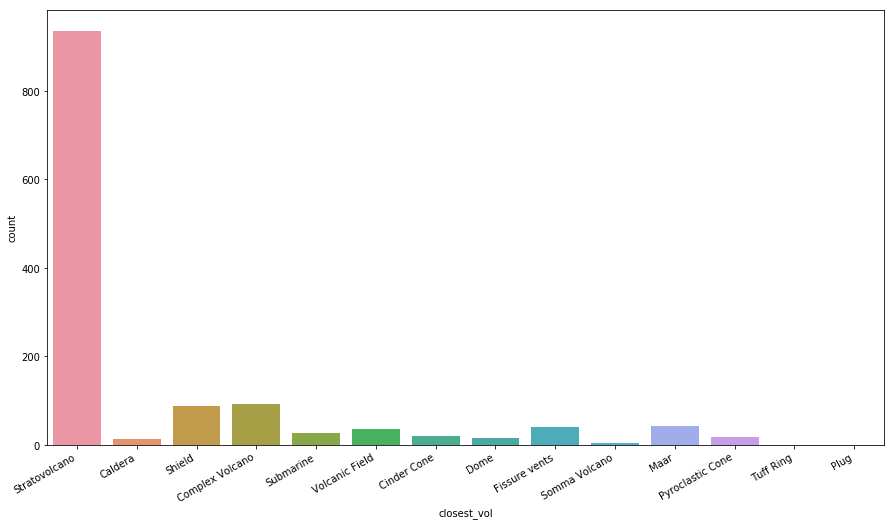

In [31]:
# At this point, we are wanting to visualize the distances between volcanoes and earthquakes. Notice here 
# how strato is way higher than the rest. This, we found, is a normalization issue. 
plt.subplots(figsize=(15, 8))
closest_vol_plot = sns.countplot(quake_vol_dist["closest_vol"])
closest_vol_plot.set_xticklabels(labels=vol_types, rotation=30, ha='right')

In [32]:
# The count between the volcano types and the dist df do not always match up. So, you need a way to make up for 
# the missing data.
quakes_closest = dict(quake_vol_dist["closest_vol"].value_counts())
volcanoe_types = dict(volcanoes_gdf['Type'].value_counts())

type_counts = list()
for key, value in volcanoe_types.items():
    key = key.strip()
    compare = {'type': key, 'volcanoes': value, 'earthquakes': quakes_closest.get(key, 0)}
    
    type_counts.append(compare)

type_counts

[{'earthquakes': 936, 'type': 'Stratovolcano', 'volcanoes': 275},
 {'earthquakes': 92, 'type': 'Caldera', 'volcanoes': 40},
 {'earthquakes': 36, 'type': 'Shield', 'volcanoes': 34},
 {'earthquakes': 41, 'type': 'Complex Volcano', 'volcanoes': 16},
 {'earthquakes': 13, 'type': 'Submarine', 'volcanoes': 11},
 {'earthquakes': 27, 'type': 'Volcanic Field', 'volcanoes': 11},
 {'earthquakes': 0, 'type': '', 'volcanoes': 10},
 {'earthquakes': 19, 'type': 'Cinder Cone', 'volcanoes': 9},
 {'earthquakes': 89, 'type': 'Dome', 'volcanoes': 8},
 {'earthquakes': 5, 'type': 'Fissure vents', 'volcanoes': 4},
 {'earthquakes': 21, 'type': 'Somma Volcano', 'volcanoes': 3},
 {'earthquakes': 1, 'type': 'Maar', 'volcanoes': 3},
 {'earthquakes': 44, 'type': 'Pyroclastic Cone', 'volcanoes': 3},
 {'earthquakes': 0, 'type': 'Flood Basalt', 'volcanoes': 2},
 {'earthquakes': 0, 'type': 'Tuff Ring', 'volcanoes': 1},
 {'earthquakes': 1, 'type': 'Plug', 'volcanoes': 1}]

In [33]:
"""CORRECTING FOR DIFFERENCES IN NUM OF VOLCANOES"""
# distance count as shown above
type_list = [vol_type['type'] for vol_type in type_counts]

dist_count = np.array([vol_type['earthquakes'] for vol_type in type_counts])
vol_count = np.array([vol_type['volcanoes'] for vol_type in type_counts])

normalized_dist = np.divide(dist_count, vol_count)

Text(0,0.5,'normalized distance')

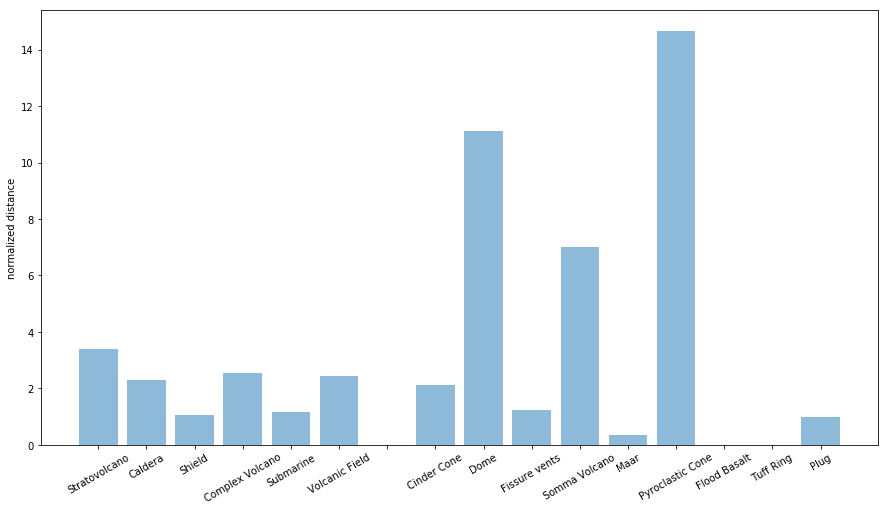

In [34]:
# Plotting out the normalized distances
# Notice the difference in the graph. Pyroclastic very obviously stands out
y_pos = np.arange(len(normalized_dist))
 
plt.figure(figsize=(15,8))
plt.bar(y_pos, normalized_dist, alpha=0.5)
plt.xticks(y_pos, type_list, rotation=30)
plt.ylabel('normalized distance')

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Caldera'),
 Text(0,0,'Shield'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Submarine'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,''),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Dome'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'Maar'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Flood Basalt')]

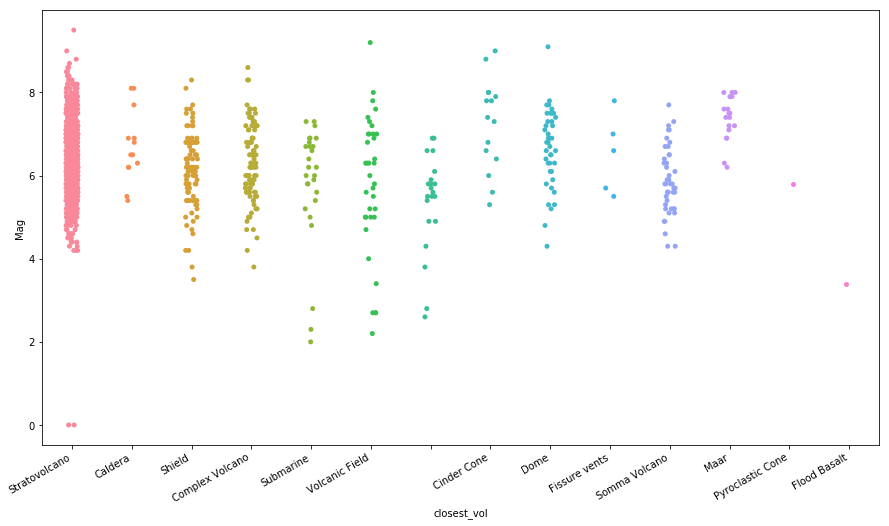

In [35]:
# Strip plot showing correlations between Magnitude and the Closest Volcano
plt.figure(figsize=(15,8))

sp = sns.stripplot(x="closest_vol", y="Mag", data=quake_vol_dist, jitter=True)
sp.set_xticklabels(labels=type_list, rotation=30, ha="right")

In [ ]:
# Get geometry column as series per type of plate
plate_types = ["SUB", "CCB", "CRB", "CTF", "OCB", "OSR", "OTF"]

plates_to_earthquake_logic = ClosestPointLogic(
    from_df=earthquakes_gdf,
    to_df=boundaries_gdf,
    categories=plate_types,
    extra_column_name='plates'
)

In [ ]:
plates_series_geometry_list = plates_to_earthquake_logic.get_geometries_from_gdf(column='STEPCLASS')

quake_plate_dist = plates_to_earthquake_logic.create_total_dist_df(
    series_geometry_list=plates_series_geometry_list
)

quake_plate_dist = plates_to_earthquake_logic.calculate_nearest(
    to_column='closest_plate',
    dist_df=quake_plate_dist
)

boundary_distances_gdf = create_gdf(df=quake_plate_dist)

POINT (141.1000061035156 38.70000076293945)
2.87796912655
POINT (43.09999847412109 40.29999923706055)
10.2164176862
POINT (-66 11)
5.51961484164
POINT (100.0999984741211 26)
14.6776777621
POINT (28.70000076293945 43.40000152587891)
8.00104201674
POINT (142.5 40.5)
1.83482369725
POINT (173 -43)
2.67404001466
POINT (141.3000030517578 40.5)
3.00886722376
POINT (48.59999847412109 40.70000076293945)
15.2904280841
POINT (33.59999847412109 40.70000076293945)
5.9830792049
POINT (-91 14)
1.15906900969
POINT (129.6000061035156 43.20000076293945)
12.1209832785
POINT (77 40)
30.2976211772
POINT (138 -35)
29.0769332117
POINT (72.30000305175781 40.79999923706055)
33.5316400884
POINT (35.29999923706055 32.20000076293945)
2.61377725821
POINT (42.65000152587891 39.13999938964844)
9.24059221888
POINT (42.70000076293945 40.90000152587891)
10.2290398461
POINT (22.96999931335449 36.36000061035156)
0.83852832951
POINT (58.20000076293945 35.20000076293945)
23.7036339365
POINT (120.5 23.5)
1.86861660059
POINT

1.21408943611
POINT (161.0160064697266 -10.93200016021729)
0.0831590896778
POINT (131.9450073242188 32.00299835205078)
1.45071626282
POINT (-75.84999847412109 19.77000045776367)
6.96258624074
POINT (-71.9739990234375 8.14900016784668)
4.61003162537
POINT (115 31.39999961853027)
11.1865151208
POINT (126.1689987182617 0.257999986410141)
0.181158072069
POINT (-87.89399719238281 12.36400032043457)
0.790896209336
POINT (-104.1460037231445 19.45700073242188)
1.21211298048
POINT (-103.6320037841797 19.45199966430664)
1.42796074424
POINT (-104.3789978027344 19.02799987792969)
0.731513734834
POINT (23.73200035095215 40.33300018310547)
4.26315239407
POINT (96.69000244140625 39.77099990844727)
26.4627670095
POINT (144.6219940185547 39.2239990234375)
0.426709470848
POINT (-118 33.63000106811523)
9.49299945874
POINT (27.14999961853027 36.51599884033203)
1.86993003712
POINT (104.4339981079102 -5.521999835968018)
2.41898346906
POINT (103.5410003662109 31.80999946594238)
19.7376184415
POINT (56 32.099

0.738915890617
POINT (99.20600128173828 45.15299987792969)
31.6958971603
POINT (47.71200180053711 34.27799987792969)
13.2217260863
POINT (-72.50299835205078 -16.77899932861328)
1.31442503732
POINT (-79.48000335693359 1.054000020027161)
0.929205145238
POINT (103.9120025634766 31.57699966430664)
19.2995993099
POINT (124.3509979248047 24.4330005645752)
1.59574940555
POINT (-79.57499694824219 0.7059999704360962)
1.03997059291
POINT (-136.6649932861328 58.36999893188477)
8.91541903004
POINT (47.86899948120117 34.25899887084961)
13.3793431945
POINT (-70.11199951171875 -33.78499984741211)
2.78181227881
POINT (112.5 -9.5)
1.19820129791
POINT (122.7919998168945 24.6870002746582)
3.05201814018
POINT (159.6450042724609 53.35100173950195)
1.76376218312
POINT (-97.14499664306641 17.45000076293945)
2.0172968619
POINT (-68.88099670410156 -20.36899948120117)
2.46461593191
POINT (120.9700012207031 21.95199966430664)
0.608871948612
POINT (-110.6360015869141 44.54800033569336)
14.706424962
POINT (-94.416

19.3688846224
POINT (121.5339965820312 23.60400009155273)
2.24933344896
POINT (69.68399810791016 36.25500106811523)
31.7662586537
POINT (73.32099914550781 35.94900131225586)
29.0826555767
POINT (-86.12799835205078 12.34700012207031)
1.82881428859
POINT (-102.9599990844727 18.45499992370605)
0.856401227743
POINT (100.5449981689453 31.35300064086914)
19.5693271362
POINT (122.8040008544922 13.41499996185303)
2.43304065405
POINT (-84.86000061035156 10.67300033569336)
1.62923066954
POINT (-78.11399841308594 4.907000064849854)
0.0513162208122
POINT (101.0780029296875 23.00300025939941)
12.9401353011
POINT (-96.60800170898438 18.23299980163574)
2.8726525699
POINT (52.95100021362305 30.53499984741211)
18.9341466716
POINT (-28.32900047302246 38.48600006103516)
37.5706471934
POINT (4.473000049591064 36.20100021362305)
6.4015821758
POINT (-76.30699920654297 -12.35099983215332)
2.04416235894
POINT (27.26300048828125 38.54000091552734)
3.56626477286
POINT (119.2799987792969 31.53300094604492)
9.970

1.43657226947
POINT (140.0619964599609 35.52500152587891)
1.47228280954
POINT (1.404000043869019 36.14300155639648)
9.32226991137
POINT (1.577000021934509 36.2130012512207)
9.13676055438
POINT (-98.23500061035156 18.17499923706055)
2.36508022351
POINT (-74.54499816894531 -13.34700012207031)
2.6369133324
POINT (88.79499816894531 27.39200019836426)
14.0631744429
POINT (15.3100004196167 40.78799819946289)
2.17396834914
POINT (15.29500007629395 40.76599884033203)
2.14801244833
POINT (50.64300155639648 34.47200012207031)
16.1460356798
POINT (50.63399887084961 34.42699813842773)
16.1379702843
POINT (139.2830047607422 -4.513000011444092)
2.90340422334
POINT (101.1679992675781 30.95599937438965)
19.4951800735
POINT (14.61400032043457 40.99499893188477)
2.23223997372
POINT (26.60700035095215 -26.625)
59.3122840286
POINT (22.97599983215332 38.15900039672852)
2.24946697251
POINT (23.17000007629395 38.09700012207031)
2.35619898133
POINT (23.29999923706055 38.19699859619141)
2.5201876095
POINT (23.

2.14528252592
POINT (115.5660018920898 25.00200080871582)
5.93547664145
POINT (-70.00499725341797 -19.09199905395508)
1.64720809289
POINT (-70.90899658203125 -17.89999961853027)
1.5585180406
POINT (-78.03099822998047 -1.008999943733215)
3.19819125633
POINT (-118.1350021362305 34.06100082397461)
9.09614833151
POINT (-77.96099853515625 -8.166000366210938)
2.97757320082
POINT (-118.1370010375977 34.02000045776367)
9.12293015056
POINT (-115.7559967041016 33.25699996948242)
11.4252086049
POINT (124.1490020751953 -8.258999824523926)
4.59412012008
POINT (140.3220062255859 35.42100143432617)
1.69283626785
POINT (26.69400024414062 -26.90500068664551)
59.2433259811
POINT (91.57900238037109 24.71299934387207)
11.0088649842
POINT (-118.0500030517578 34.08000183105469)
9.14511286586
POINT (121.0849990844727 12.35499954223633)
4.43585108352
POINT (121.6790008544922 23.98600006103516)
2.6545898712
POINT (95.12599945068359 25.10499954223633)
11.7933646689
POINT (160.9329986572266 -10.31999969482422)
0

8.71723466689
POINT (127.7730026245117 1.042999982833862)
1.42408726065
POINT (30.08099937438965 0.5580000281333923)
33.833785623
POINT (104.254997253418 -4.999000072479248)
2.80616129413
POINT (60.53200149536133 30.78800010681152)
26.3370672247
POINT (52.63800048828125 29.14299964904785)
18.9952422905
POINT (-72.81400299072266 19.94099998474121)
6.53840006984
POINT (67.12400054931641 36.93399810791016)
32.6947030069
POINT (-4.089000225067139 35.25)
14.8643424177
POINT (112.9339981079102 -10.40900039672852)
0.40782087717
POINT (121.8499984741211 24.45499992370605)
3.15019496268
POINT (-75.97100067138672 2.907999992370605)
2.63852235386
POINT (-67.51200103759766 -13.85999965667725)
6.79993927173
POINT (52.67100143432617 29.05299949645996)
19.0536380489
POINT (-97.31199645996094 14.88700008392334)
0.480484389288
POINT (-0.08399999886751175 35.4640007019043)
10.9418319058
POINT (27.40500068664551 -26.44700050354004)
60.0885314596
POINT (118.7190017700195 22.55500030517578)
1.96346948753
P

2.61114988839
POINT (102.0309982299805 -4.760000228881836)
1.304895
POINT (101.9530029296875 -4.151000022888184)
1.60684903975
POINT (33.00500106811523 40.73699951171875)
6.13688194394
POINT (101.8479995727539 -4.651000022888184)
1.23227149564
POINT (121.1809997558594 23.86800003051758)
2.35183689496
POINT (139.1710052490234 34.22200012207031)
0.72870789931
POINT (-86.06600189208984 11.92800045013428)
1.59621842132
POINT (29.3439998626709 40.85699844360352)
5.43188540312
POINT (70.94300079345703 36.24499893188477)
30.8847283191
POINT (102.2399978637695 25.72599983215332)
15.7395570938
POINT (-80.52200317382812 -1.945999979972839)
1.0567137696
POINT (30.80599975585938 -7.965000152587891)
42.3172785516
POINT (-77.81099700927734 7.091000080108643)
0.71483133241
POINT (4.837999820709229 36.4370002746582)
5.97408819402
POINT (152.2680053710938 -3.996000051498413)
1.68847762643
POINT (49.92900085449219 40.19800186157227)
16.3509833503
POINT (49.9119987487793 40.1609992980957)
16.3227164983
P

17.5007467304
POINT (-76.41400146484375 -5.721000194549561)
5.37405194796
POINT (73.58399963378906 34.46500015258789)
27.7888606436
POINT (73.92900085449219 33.97700119018555)
27.1950727565
POINT (26.75300025939941 38.15800094604492)
3.48535997973
POINT (107.7979965209961 23.60400009155273)
12.6888080951
POINT (108.2259979248047 9.972999572753906)
12.8442509085
POINT (115.6630020141602 29.7140007019043)
9.39431940345
POINT (55.83300018310547 26.7859992980957)
22.783347187
POINT (29.78899955749512 -6.245999813079834)
40.5803658675
POINT (71.12000274658203 36.28499984741211)
30.7932376025
POINT (79.20099639892578 30.45999908447266)
21.1176413458
POINT (88.38800048828125 27.38199996948242)
14.1537728035
POINT (33.58300018310547 -21.32399940490723)
55.616088086
POINT (73.88700103759766 33.12900161743164)
26.59797327
POINT (127.213996887207 -3.595000028610229)
1.75500693806
POINT (5.328000068664551 36.62300109863281)
5.45012511567
POINT (55.68500137329102 27.57399940490723)
22.3786240142
PO

1.35650380385
POINT (-97.08000183105469 19.27000045776367)
13.8006483715
POINT (44.09999847412109 42)
4.19499629371
POINT (10.30000019073486 44.29999923706055)
5.6154737471
POINT (105.3170013427734 36.60100173950195)
8.05821340079
POINT (-68.40000152587891 -32.70000076293945)
12.3282310616
POINT (39.44499969482422 15.60999965667725)
16.3062574893
POINT (127.2570037841797 7.896999835968018)
5.58120074354
POINT (139.8000030517578 35.20000076293945)
0.431389898085
POINT (122.0400009155273 24.50600051879883)
0.840163565452
POINT (122 24.5)
0.810304880894
POINT (-70.75499725341797 -28.55299949645996)
10.1788151648
POINT (130.1000061035156 32.70000076293945)
2.10949169105
POINT (130.1000061035156 32.70000076293945)
2.10949169105
POINT (160.7610015869141 53.85300064086914)
10.4091143017
POINT (101.2580032348633 30.55299949645996)
4.62482678694
POINT (162.5850067138672 55.41500091552734)
10.6957029435
POINT (59.20000076293945 35.20000076293945)
8.23406592156
POINT (139.0839996337891 35.4049987

1.64937309339
POINT (-90.91300201416016 13.77999973297119)
5.54592330343
POINT (-74.91999816894531 -14.97500038146973)
3.90109938898
POINT (20.39999961853027 41.70000076293945)
3.58694220475
POINT (36.45000076293945 40.67100143432617)
3.09279073073
POINT (30.5 40.79999923706055)
7.15106277479
POINT (-101.5 17.75)
16.6450331631
POINT (-72 -30.75)
12.6296852296
POINT (30.5 40.59999847412109)
7.05810840298
POINT (110 -9.5)
11.0505375887
POINT (134 35.25)
4.03595800275
POINT (34 41)
4.55615012922
POINT (121.5 22.89999961853027)
1.12183852018
POINT (-68.75 -31.25)
11.1689726027
POINT (32.5 41.5)
5.93552895705
POINT (84 44)
14.2491432023
POINT (54.5 36.79999923706055)
7.52371620291
POINT (26.70000076293945 39.40000152587891)
6.54537720186
POINT (136 33.75)
2.90746298343
POINT (136.75 34.75)
1.77593149225
POINT (142.5 41.25)
4.96608034571
POINT (35.79999923706055 37.40000152587891)
0.990002786222
POINT (-70.5 -33.25)
13.7678592744
POINT (119 39.5)
0.767259161163
POINT (63 24.5)
2.03143003818


1.01685667092
POINT (20.45599937438965 41.37900161743164)
3.26863615915
POINT (73.77400207519531 17.39399909973145)
10.4966645786
POINT (-69.947998046875 -21.86400032043457)
6.42218033896
POINT (13 38)
1.6962962595
POINT (24.94599914550781 39.37200164794922)
4.8304183227
POINT (132.1920013427734 32.48199844360352)
3.6709040354
POINT (143.3459930419922 40.90299987792969)
5.85226105558
POINT (172.1230010986328 -41.74300003051758)
1.30985411319
POINT (-77.1510009765625 -5.558000087738037)
3.87437496755
POINT (-100.2590026855469 17.51499938964844)
15.4356012264
POINT (122.0780029296875 16.38400077819824)
5.4941224376
POINT (-97.77100372314453 16.49399948120117)
12.7630829477
POINT (119.6900024414062 0.05799999833106995)
4.02594108215
POINT (58.95999908447266 34.04499816894531)
7.05894698131
POINT (58.21200180053711 34.07199859619141)
6.90173860736
POINT (32.45199966430664 41.77099990844727)
6.15965706121
POINT (-62.71900177001953 10.73099994659424)
6.60622135933
POINT (-92.66000366210938 1

14.7428522833
POINT (15.07299995422363 38.38100051879883)
0.0124610336392
POINT (142.1049957275391 38.23500061035156)
4.14313814087
POINT (142.0090026855469 38.2239990234375)
4.08393454241
POINT (23.25699996948242 40.73199844360352)
3.962234934
POINT (23.30299949645996 40.7599983215332)
4.01527758424
POINT (23.11199951171875 40.71799850463867)
3.84506156667
POINT (-90.98999786376953 14.75800037384033)
6.26980684158
POINT (57.38199996948242 33.24200057983398)
5.95100833523
POINT (-96.60299682617188 16.01099967956543)
11.509306413
POINT (49.63399887084961 32.12799835205078)
0.783996159761
POINT (122.0090026855469 23.21699905395508)
1.60001260496
POINT (59.47100067138672 33.90900039672852)
7.09964004221
POINT (-72.55300140380859 -16.53700065612793)
4.11907281224
POINT (-101.2210006713867 17.75799942016602)
16.400239902
POINT (101.1060028076172 23.16200065612793)
5.39525125229
POINT (19.1560001373291 41.99900054931641)
4.04392581013
POINT (115.8639984130859 -8.345000267028809)
5.2498839303

0.818244306631
POINT (37.90999984741211 38.00699996948242)
0.0653197232928
POINT (-62.9109992980957 10.57299995422363)
6.4019769543
POINT (51.55699920654297 29.9109992980957)
0.600739327059
POINT (-117.8399963378906 33.06600189208984)
1.30063592865
POINT (-69.42400360107422 10.74300003051758)
0.634833799234
POINT (100.7539978027344 29.28000068664551)
3.61021213727
POINT (26.27099990844727 45.52099990844727)
9.52454484725
POINT (22.17600059509277 37.07199859619141)
2.01375378037
POINT (-89.16500091552734 13.79100036621094)
4.35665378625
POINT (121.7269973754883 23.97400093078613)
0.995797508235
POINT (26.00300025939941 43.27799987792969)
7.7062579575
POINT (19.23500061035156 50.30400085449219)
12.2338853008
POINT (10.1540002822876 43.51499938964844)
4.83496173515
POINT (1.38699996471405 35.91899871826172)
0.388732782018
POINT (147.6649932861328 -6.025000095367432)
0.97892953968
POINT (176.9210052490234 -38.01499938964844)
2.93042022284
POINT (-70.09999847412109 -24.39500045776367)
7.220

0.203726614512
POINT (73.58799743652344 42.11100006103516)
7.51429817871
POINT (66.81999969482422 29.21100044250488)
0.75658230004
POINT (-87.37999725341797 11.72700023651123)
1.66189189924
POINT (52.14699935913086 29.13199996948242)
1.04931762558
POINT (26.65999984741211 -6.151000022888184)
16.4191637627
POINT (31.14399909973145 29.7140007019043)
4.48695789553
POINT (-76.76399993896484 7.092999935150146)
1.16259803427
POINT (31.53499984741211 29.7549991607666)
4.11016591931
POINT (-4.290999889373779 31.27499961853027)
2.82366361713
POINT (45.09600067138672 42.56100082397461)
5.11569268215
POINT (121.8320007324219 -8.498000144958496)
1.70745276217
POINT (100.7519989013672 26.32799911499023)
3.55708198145
POINT (26.79999923706055 -28.02799987792969)
1.27640721602
POINT (-76.59400177001953 18.05200004577637)
6.27754808384
POINT (144.1940002441406 43.02199935913086)
5.30972344608
POINT (144.1410064697266 43.02399826049805)
5.27799226292
POINT (101.4150009155273 25.82600021362305)
4.367438

7.48636333613
POINT (120.8769989013672 23.81900024414062)
0.359160233185
POINT (121.0869979858398 23.8129997253418)
0.545021937362
POINT (29.35000038146973 40.73600006103516)
8.1544980674
POINT (-96.90499877929688 16.05500030517578)
11.7931517208
POINT (120.443000793457 23.5310001373291)
0.00386414501951
POINT (30.72400093078613 40.69499969482422)
6.90409673276
POINT (30.24699974060059 40.7400016784668)
7.34709654308
POINT (31.2189998626709 40.80300140380859)
6.52917124068
POINT (102.8450012207031 24.58600044250488)
6.21203206386
POINT (168.2389984130859 -16.31599998474121)
2.78646175309
POINT (42.35400009155273 40.48199844360352)
2.10482022035
POINT (119.7760009765625 15.7790002822876)
4.92301582259
POINT (124.515998840332 11.29599952697754)
9.44306239008
POINT (105.4980010986328 -6.822999954223633)
14.3541947468
POINT (-1.315999984741211 35.20999908447266)
0.56275687406
POINT (101.1179962158203 25.54899978637695)
4.23509047342
POINT (101.0709991455078 25.5669994354248)
4.18547742299


4.44399348604
POINT (73.58399963378906 34.46500015258789)
0.585250341629
POINT (73.92900085449219 33.97700119018555)
0.446536900882
POINT (26.75300025939941 38.15800094604492)
6.46270291887
POINT (107.7979965209961 23.60400009155273)
5.82576601499
POINT (108.2259979248047 9.972999572753906)
7.80830498234
POINT (115.6630020141602 29.7140007019043)
3.49542400875
POINT (55.83300018310547 26.7859992980957)
0.223897245548
POINT (29.78899955749512 -6.245999813079834)
15.7459790143
POINT (71.12000274658203 36.28499984741211)
2.08866516116
POINT (79.20099639892578 30.45999908447266)
0.83259440313
POINT (88.38800048828125 27.38199996948242)
0.481319525012
POINT (33.58300018310547 -21.32399940490723)
2.45156961741
POINT (73.88700103759766 33.12900161743164)
0.271434140403
POINT (127.213996887207 -3.595000028610229)
1.74718102144
POINT (5.328000068664551 36.62300109863281)
0.49525348762
POINT (55.68500137329102 27.57399940490723)
0.536757689011
POINT (48.77999877929688 33.5)
1.29609000056
POINT (

2.47463633692
POINT (125 6)
4.82251604456
POINT (104 29)
1.34433269731
POINT (-74 4)
7.50854140296
POINT (117.2429962158203 23.54000091552734)
2.19384999689
POINT (-117.4400024414062 33.8120002746582)
1.85306820914
POINT (123.5630035400391 5.652999877929688)
5.632234032
POINT (150.2530059814453 46.8120002746582)
10.663027472
POINT (-67.63099670410156 18.47299957275391)
5.98542968785
POINT (152.6289978027344 -5.47700023651123)
1.87795864506
POINT (122.0800018310547 23.8129997253418)
0.997473382776
POINT (-97.08000183105469 19.27000045776367)
8.53992706459
POINT (44.09999847412109 42)
9.27635880628
POINT (10.30000019073486 44.29999923706055)
8.03224195393
POINT (105.3170013427734 36.60100173950195)
7.00423487766
POINT (-68.40000152587891 -32.70000076293945)
11.199489762
POINT (39.44499969482422 15.60999965667725)
0.249671231954
POINT (127.2570037841797 7.896999835968018)
5.66722303463
POINT (139.8000030517578 35.20000076293945)
8.5007800808
POINT (122.0400009155273 24.50600051879883)
0.3

0.135458060441
POINT (-101.5 17.75)
11.5434325917
POINT (-72 -30.75)
9.4508382697
POINT (30.5 40.59999847412109)
0.0599225993314
POINT (110 -9.5)
13.1306311755
POINT (134 35.25)
4.16955753048
POINT (34 41)
3.25058102499
POINT (121.5 22.89999961853027)
1.79257004505
POINT (-68.75 -31.25)
9.74936200983
POINT (32.5 41.5)
1.94609275216
POINT (84 44)
18.5397662607
POINT (54.5 36.79999923706055)
15.1654580032
POINT (26.70000076293945 39.40000152587891)
0.135840620133
POINT (136 33.75)
4.48724971447
POINT (136.75 34.75)
5.68158516613
POINT (142.5 41.25)
12.785323852
POINT (35.79999923706055 37.40000152587891)
0.944700513875
POINT (-70.5 -33.25)
11.7581607405
POINT (119 39.5)
2.73120211629
POINT (63 24.5)
5.83902217841
POINT (5 36)
10.4693152116
POINT (31.79999923706055 38.20000076293945)
2.61102887208
POINT (-163.5 52.75)
51.6542301172
POINT (41.20000076293945 39.29999923706055)
5.38661854061
POINT (-124.5 49.75)
18.7606072663
POINT (-70.5 -26.5)
5.01914773642
POINT (-69 19.25)
6.16732364969


1.88829871103
POINT (78.89199829101562 28.61599922180176)
8.95868462494
POINT (41.58000183105469 39.1609992980957)
5.66239987244
POINT (100.088996887207 27.45700073242188)
4.87122978272
POINT (-78.68399810791016 -10.80700016021729)
5.24101606362
POINT (21.17600059509277 38.87400054931641)
0.437517310917
POINT (-70.65499877929688 -25.50200080871582)
4.04569623492
POINT (-74.79900360107422 2.888999938964844)
7.4265185751
POINT (112.9459991455078 -9.168000221252441)
10.7136001945
POINT (116.6009979248047 38.51599884033203)
1.7660099496
POINT (96.23200225830078 5.084000110626221)
0.553013186366
POINT (21.29100036621094 39.55199813842773)
1.11921002398
POINT (30.73999977111816 40.63199996948242)
0.0229173731392
POINT (40.40800094604492 39.50199890136719)
4.81906104628
POINT (-73.072998046875 6.788000106811523)
6.02882399398
POINT (-67.30999755859375 10.55500030517578)
0.653321675965
POINT (100.2320022583008 31.63100051879883)
5.89653708634
POINT (122.2210006713867 24.4640007019043)
0.434416

4.60329861817
POINT (-76.15899658203125 7.35099983215332)
4.52845569423
POINT (-67.77999877929688 -31.08200073242188)
9.58185345453
POINT (56.57799911499023 27.6870002746582)
10.6987503189
POINT (56.41299819946289 30.9109992980957)
11.0765612311
POINT (139.2940063476562 34.80300140380859)
7.86923377086
POINT (-91.39900207519531 14.26799964904785)
0.991818229008
POINT (15.98999977111816 38.04600143432617)
0.425695171149
POINT (66.23400115966797 29.92799949645996)
1.68761882608
POINT (-99.78199768066406 16.93199920654297)
9.6443859715
POINT (15.07299995422363 38.38100051879883)
0.546313619104
POINT (142.1049957275391 38.23500061035156)
12.0598219087
POINT (142.0090026855469 38.2239990234375)
11.9752548076
POINT (23.25699996948242 40.73199844360352)
1.10345752599
POINT (23.30299949645996 40.7599983215332)
1.09433216046
POINT (23.11199951171875 40.71799850463867)
1.19670316978
POINT (-90.98999786376953 14.75800037384033)
0.968991156203
POINT (57.38199996948242 33.24200057983398)
10.9077830

15.7399731896
POINT (-117.8399963378906 33.06600189208984)
2.1239607361
POINT (-69.42400360107422 10.74300003051758)
1.03601505195
POINT (100.7539978027344 29.28000068664551)
4.41644294989
POINT (26.27099990844727 45.52099990844727)
4.83343028437
POINT (22.17600059509277 37.07199859619141)
1.26751147338
POINT (-89.16500091552734 13.79100036621094)
1.05813108906
POINT (121.7269973754883 23.97400093078613)
0.732933057932
POINT (26.00300025939941 43.27799987792969)
2.78659805897
POINT (19.23500061035156 50.30400085449219)
11.4277424249
POINT (10.1540002822876 43.51499938964844)
7.56913941846
POINT (1.38699996471405 35.91899871826172)
7.53695048177
POINT (147.6649932861328 -6.025000095367432)
2.41663615412
POINT (176.9210052490234 -38.01499938964844)
0.415840734982
POINT (-70.09999847412109 -24.39500045776367)
2.89524982247
POINT (-77.66600036621094 0.03999999910593033)
7.95456131596
POINT (-77.78700256347656 0.0820000022649765)
7.86906408676
POINT (20.20599937438965 51.36899948120117)
12.

3.62088275419
POINT (52.14699935913086 29.13199996948242)
15.1033489436
POINT (26.65999984741211 -6.151000022888184)
2.94045998095
POINT (31.14399909973145 29.7140007019043)
3.61054264241
POINT (-76.76399993896484 7.092999935150146)
3.93619276975
POINT (31.53499984741211 29.7549991607666)
3.3024508614
POINT (-4.290999889373779 31.27499961853027)
3.44221261078
POINT (45.09600067138672 42.56100082397461)
10.4152523828
POINT (121.8320007324219 -8.498000144958496)
6.16042094419
POINT (100.7519989013672 26.32799911499023)
4.46251066506
POINT (26.79999923706055 -28.02799987792969)
0.250953024245
POINT (-76.59400177001953 18.05200004577637)
7.59676315573
POINT (144.1940002441406 43.02199935913086)
11.1567203509
POINT (144.1410064697266 43.02399826049805)
11.1463898065
POINT (101.4150009155273 25.82600021362305)
3.98063839691
POINT (86.14399719238281 42.20000076293945)
19.1918497732
POINT (-178.1620025634766 -14.40900039672852)
1.54516289709
POINT (87.35600280761719 29.00900077819824)
17.21422

1.00450507621
POINT (29.35000038146973 40.73600006103516)
0.657778454225
POINT (-96.90499877929688 16.05500030517578)
6.65055882944
POINT (120.443000793457 23.5310001373291)
1.62080902176
POINT (30.72400093078613 40.69499969482422)
0.0809783031895
POINT (30.24699974060059 40.7400016784668)
0.0230861825369
POINT (31.2189998626709 40.80300140380859)
0.488701795493
POINT (102.8450012207031 24.58600044250488)
3.10561718298
POINT (168.2389984130859 -16.31599998474121)
2.80112198696
POINT (42.35400009155273 40.48199844360352)
6.98183624836
POINT (119.7760009765625 15.7790002822876)
5.29803982099
POINT (124.515998840332 11.29599952697754)
9.68593107287
POINT (105.4980010986328 -6.822999954223633)
12.2625217411
POINT (-1.315999984741211 35.20999908447266)
4.7670720525
POINT (101.1179962158203 25.54899978637695)
4.34668425145
POINT (101.0709991455078 25.5669994354248)
4.38619582325
POINT (103.6539993286133 24.14800071716309)
2.59909766982
POINT (58.2130012512207 35.23799896240234)
11.2209142934

1.49321307338
POINT (27.43499946594238 -26.4680004119873)
0.552794484226
POINT (125.0299987792969 46.88399887084961)
5.22811665752
POINT (-76.41400146484375 -5.721000194549561)
7.4582056533
POINT (73.58399963378906 34.46500015258789)
4.44711885509
POINT (73.92900085449219 33.97700119018555)
4.48957422556
POINT (26.75300025939941 38.15800094604492)
0.808933483184
POINT (107.7979965209961 23.60400009155273)
0.186234963925
POINT (108.2259979248047 9.972999572753906)
9.59247264963
POINT (115.6630020141602 29.7140007019043)
4.311787403
POINT (55.83300018310547 26.7859992980957)
11.5461255983
POINT (29.78899955749512 -6.245999813079834)
0.0795796326354
POINT (71.12000274658203 36.28499984741211)
4.52792150293
POINT (79.20099639892578 30.45999908447266)
8.95964851939
POINT (88.38800048828125 27.38199996948242)
15.5151137242
POINT (33.58300018310547 -21.32399940490723)
0.468401093881
POINT (73.88700103759766 33.12900161743164)
4.12502868556
POINT (127.213996887207 -3.595000028610229)
5.0588553

1.33404992181
POINT (116 -7)
4.41151096564
POINT (114 31)
3.65675881075
POINT (125 6)
4.87150295084
POINT (104 29)
6.65474995774
POINT (-74 4)
0.44123463146
POINT (117.2429962158203 23.54000091552734)
1.89567455441
POINT (-117.4400024414062 33.8120002746582)
0.813205805597
POINT (123.5630035400391 5.652999877929688)
4.29909108402
POINT (150.2530059814453 46.8120002746582)
10.663027472
POINT (-67.63099670410156 18.47299957275391)
2.16296042609
POINT (152.6289978027344 -5.47700023651123)
0.727172397467
POINT (122.0800018310547 23.8129997253418)
0.534758211808
POINT (-97.08000183105469 19.27000045776367)
9.83198082943
POINT (44.09999847412109 42)
4.25795626359
POINT (10.30000019073486 44.29999923706055)
8.37443424211
POINT (105.3170013427734 36.60100173950195)
9.52215260428
POINT (-68.40000152587891 -32.70000076293945)
11.2011273882
POINT (39.44499969482422 15.60999965667725)
0.278065188717
POINT (127.2570037841797 7.896999835968018)
5.99556669701
POINT (139.8000030517578 35.2000007629394

3.41829543818
POINT (92.47799682617188 12.14900016784668)
2.23534013011
POINT (43.29999923706055 39.5)
2.33704888524
POINT (102.3000030517578 31.70000076293945)
6.26923285374
POINT (39.40000152587891 39.70000076293945)
0.157257451062
POINT (132 32)
2.56636182172
POINT (120.390998840332 23.25099945068359)
1.24974002428
POINT (99.14499664306641 21.07600021362305)
3.2832197727
POINT (100.3000030517578 23.10000038146973)
4.37009033888
POINT (-79.90200042724609 0.01200000010430813)
2.51679982251
POINT (-90.91300201416016 13.77999973297119)
4.03509047854
POINT (-74.91999816894531 -14.97500038146973)
2.98402963644
POINT (20.39999961853027 41.70000076293945)
3.22921274544
POINT (36.45000076293945 40.67100143432617)
0.0969367120143
POINT (30.5 40.79999923706055)
0.338639478429
POINT (-101.5 17.75)
13.8583090599
POINT (-72 -30.75)
9.11168178768
POINT (30.5 40.59999847412109)
0.274001830385
POINT (110 -9.5)
10.608365991
POINT (134 35.25)
5.23931789454
POINT (34 41)
0.114319373995
POINT (121.5 22.

POINT (28.20800018310547 40.25)
0.382561568777
POINT (125.9649963378906 -2.454999923706055)
1.64289167709
POINT (-70.70999908447266 -25.66699981689453)
3.93309248687
POINT (23.82500076293945 39.22900009155273)
0.324996698709
POINT (-71.21199798583984 -32.49200057983398)
10.7709988091
POINT (22.29899978637695 38.3390007019043)
0.433368524839
POINT (138.2779998779297 34.84199905395508)
0.971349864281
POINT (-122.3349990844727 47.31700134277344)
7.30853060645
POINT (22.42600059509277 38.39099884033203)
0.324037595713
POINT (-95.84600067138672 16.17799949645996)
8.12332868847
POINT (87.75499725341797 43.84000015258789)
16.7830908416
POINT (21.75699996948242 39.04399871826172)
1.23752191869
POINT (103.1709976196289 26.15999984741211)
5.25849186039
POINT (114.9629974365234 37.38800048828125)
2.56000224309
POINT (122.6949996948242 24.30699920654297)
0.917474445638
POINT (29.87299919128418 0.8420000076293945)
3.4452944599
POINT (114.9909973144531 37.55099868774414)
2.72317511133
POINT (69.1299

2.63683638
POINT (13.26599979400635 46.3849983215332)
9.01282172329
POINT (-74.41899871826172 -11.65999984741211)
1.41184217138
POINT (63.42800140380859 40.37300109863281)
11.2647337016
POINT (98.93000030517578 24.50099945068359)
2.61339609531
POINT (98.61000061035156 24.58099937438965)
2.29198621519
POINT (140.1089935302734 -4.531000137329102)
0.329437867734
POINT (40.4630012512207 38.32699966430664)
0.533368584391
POINT (114.7740020751953 -8.227999687194824)
5.78314858313
POINT (98.66699981689453 24.76799964904785)
2.25821859214
POINT (117.8880004882812 39.60499954223633)
0.345173089966
POINT (118.359001159668 39.72299957275391)
0.730919130124
POINT (104.0879974365234 32.75299835205078)
8.32449634677
POINT (124.088996887207 6.291999816894531)
4.96897924555
POINT (122.9599990844727 7.258999824523926)
5.93292920744
POINT (29.01499938964844 37.74300003051758)
0.737132348692
POINT (104.181999206543 32.48099899291992)
8.23870995512
POINT (13.18099975585938 46.3390007019043)
8.98814543179


0.527987369216
POINT (120.7850036621094 18.20599937438965)
2.03431751706
POINT (-70.50199890136719 -26.53899955749512)
4.80840744376
POINT (120.8410034179688 1.151000022888184)
1.65082319717
POINT (-113.8000030517578 44.07799911499023)
10.4355575213
POINT (42.17599868774414 40.32699966430664)
1.71336805123
POINT (115.2040023803711 35.22299957275391)
0.464286360022
POINT (5.346000194549561 50.69599914550781)
16.4642806935
POINT (72.92900085449219 39.35100173950195)
7.67038331661
POINT (151.8950042724609 -5.446000099182129)
1.32371261641
POINT (-13.51099967956543 11.86200046539307)
23.4578096258
POINT (70.677001953125 36.40499877929688)
5.41523318571
POINT (118.7259979248047 -2.865999937057495)
0.750296938719
POINT (-116 47.5)
11.0684586551
POINT (70.44599914550781 34.56399917602539)
3.56296250546
POINT (70.83999633789062 36.44699859619141)
5.47203668309
POINT (138.8710021972656 29.37199974060059)
5.51629480675
POINT (10.19400024414062 43.61600112915039)
7.90787658208
POINT (13.888999938

1.60562712816
POINT (49.21599960327148 37.00099945068359)
4.79245962611
POINT (49.78499984741211 36.63100051879883)
5.19697896274
POINT (70.77500152587891 36.44800186157227)
5.46650481012
POINT (121.1800003051758 15.7209997177124)
0.21183982835
POINT (-78.48300170898438 -0.1720000058412552)
1.57221052871
POINT (26.83699989318848 -28.09000015258789)
0.242862324086
POINT (27.34900093078613 -26.38999938964844)
0.84255258779
POINT (103.7180023193359 37.09600067138672)
10.7250516853
POINT (70.42900085449219 35.09000015258789)
4.08757856665
POINT (55.45700073242188 28.24200057983398)
2.28823812559
POINT (97.40499877929688 3.938999891281128)
1.09511054574
POINT (15.40200042724609 37.2859992980957)
0.0603746542651
POINT (121.6449966430664 23.88299942016602)
0.39540021632
POINT (22.34600067138672 40.97700119018555)
1.91220580932
POINT (-84.22899627685547 9.982000350952148)
5.2129015283
POINT (95.88999938964844 23.55900001525879)
0.0625420073773
POINT (70.40299987792969 35.94400024414062)
4.9401

10.2661973439
POINT (68.16500091552734 29.97900009155273)
0.883376259429
POINT (48.06900024414062 38.10800170898438)
4.0172437146
POINT (76.81700134277344 39.45000076293945)
7.35025844078
POINT (71.52300262451172 34.79000091552734)
3.98984894059
POINT (76.83000183105469 39.52500152587891)
7.42636840033
POINT (76.89199829101562 39.5359992980957)
7.44711242876
POINT (59.81000137329102 33.84799957275391)
7.8278307659
POINT (59.88000106811523 33.39899826049805)
7.43759654219
POINT (70.96800231933594 36.46699905395508)
5.50696050111
POINT (80.08300018310547 23.07200050354004)
9.6077591027
POINT (-7.230999946594238 42.83000183105469)
6.95483874662
POINT (-63.53200149536133 10.44999980926514)
0.0697811718463
POINT (26.61899948120117 -26.85700035095215)
0.0231243696519
POINT (12.7810001373291 43.07799911499023)
6.0343456668
POINT (119.6579971313477 -3.773000001907349)
0.214236938231
POINT (-71.16699981689453 -30.87800025939941)
9.15680056388
POINT (-71.38700103759766 46.77099990844727)
26.5446

0.200811391832
POINT (77.14199829101562 39.30500030517578)
7.26564135704
POINT (3.694000005722046 36.88000106811523)
9.92337297598
POINT (72.76300048828125 42.95399856567383)
11.1519027648
POINT (128.8789978027344 2.348999977111816)
0.683671510814
POINT (3.592000007629395 36.8650016784668)
9.82139123023
POINT (49.4630012512207 33.02399826049805)
3.79680602908
POINT (54.16500091552734 28.31100082397461)
3.25714822273
POINT (101.2600021362305 25.95800018310547)
4.11891991335
POINT (92.31700134277344 22.86800003051758)
3.59366822892
POINT (92.16799926757812 22.74300003051758)
3.74435749027
POINT (92.31600189208984 22.83600044250488)
3.59510330313
POINT (119.7180023193359 43.77899932861328)
4.45179743062
POINT (-70.69300079345703 19.76600074768066)
0.715906474906
POINT (143.8780059814453 41.86399841308594)
8.27582441905
POINT (87.81700134277344 50.03099822998047)
21.5815916338
POINT (101.2559967041016 25.88199996948242)
4.13943900898
POINT (100.9779968261719 38.38600158691406)
11.244861788

4.54192180249
POINT (99.94899749755859 20.70499992370605)
3.9286594992
POINT (140 38.20000076293945)
3.27679063436
POINT (88.06400299072266 27.72299957275391)
8.64288062308
POINT (43.5 38.59999847412109)
1.58946513528
POINT (141.1000061035156 38.70000076293945)
2.80364704496
POINT (43.09999847412109 40.29999923706055)
21.6443131968
POINT (-66 11)
9.08312066418
POINT (100.0999984741211 26)
13.872033804
POINT (28.70000076293945 43.40000152587891)
10.288444685
POINT (142.5 40.5)
3.75460517232
POINT (173 -43)
12.3271544973
POINT (141.3000030517578 40.5)
2.5595850303
POINT (48.59999847412109 40.70000076293945)
18.6954520133
POINT (33.59999847412109 40.70000076293945)
13.8836316127
POINT (-91 14)
10.3973483158
POINT (129.6000061035156 43.20000076293945)
8.99340755558
POINT (77 40)
19.6786866432
POINT (138 -35)
28.2273947965
POINT (72.30000305175781 40.79999923706055)
17.9564118724
POINT (35.29999923706055 32.20000076293945)
16.3300714005
POINT (42.65000152587891 39.13999938964844)
21.1304251

6.15313024784
POINT (-96.61399841308594 16.05299949645996)
9.04806057273
POINT (176.0249938964844 -39.77199935913086)
16.6942906419
POINT (102.4580001831055 -5.433000087738037)
10.6078413753
POINT (22.66600036621094 41.33700180053711)
4.33568397342
POINT (-85.69999694824219 13.19999980926514)
5.52065447863
POINT (46 39.20000076293945)
18.9146846529
POINT (1.5 54.08000183105469)
17.3837921711
POINT (89.96499633789062 46.57099914550781)
32.2880107267
POINT (67.1719970703125 29.47299957275391)
5.52403838575
POINT (139.3809967041016 36.02099990844727)
1.41585003912
POINT (161.0160064697266 -10.93200016021729)
7.09354086155
POINT (131.9450073242188 32.00299835205078)
8.42570329805
POINT (-75.84999847412109 19.77000045776367)
4.59326416067
POINT (-71.9739990234375 8.14900016784668)
5.09980766854
POINT (115 31.39999961853027)
10.790553465
POINT (126.1689987182617 0.257999986410141)
2.20316927604
POINT (-87.89399719238281 12.36400032043457)
6.88940975935
POINT (-104.1460037231445 19.4570007324

7.20658559418
POINT (29.60000038146973 32.20000076293945)
11.1687628059
POINT (-84.5 10)
2.89980206221
POINT (101.6999969482422 26.60000038146973)
15.2826077052
POINT (19.29999923706055 47.5)
8.43709060964
POINT (30.5 40)
10.7063749234
POINT (35.5 35.5)
15.6859320412
POINT (67.47899627685547 35.04199981689453)
10.9381432997
POINT (26.02599906921387 36.61700057983398)
6.16273837551
POINT (95.802001953125 21.9689998626709)
8.26580067197
POINT (70 23)
5.1604949375
POINT (140.3099975585938 35.64199829101562)
0.977864134127
POINT (54.40499877929688 27.28300094604492)
4.45083618439
POINT (8.899999618530273 36.20000076293945)
1.41721966619
POINT (121.5169982910156 23.91699981689453)
1.02143784096
POINT (22.60700035095215 39.26699829101562)
2.9399536025
POINT (28.60899925231934 36.38700103759766)
8.74232840667
POINT (31.04199981689453 40.67200088500977)
11.3826824979
POINT (52.70100021362305 36.09000015258789)
12.7271273806
POINT (-99.2969970703125 16.88100051879883)
6.24024790466
POINT (99.20

22.7027674628
POINT (55.88700103759766 37.83599853515625)
13.5334929241
POINT (-72.56300354003906 -1.485999941825867)
11.5488992797
POINT (145.4709930419922 -4.907000064849854)
2.97362886333
POINT (121.3629989624023 22.8390007019043)
1.39336328103
POINT (-80.66200256347656 -4.078999996185303)
11.1379213767
POINT (-118.3919982910156 34.4010009765625)
15.8866644352
POINT (95.02799987792969 32.17800140380859)
17.9702978925
POINT (55.60800170898438 28.26399993896484)
4.42110946845
POINT (100.9929962158203 22.95299911499023)
12.0528111942
POINT (29.74600028991699 37.55500030517578)
9.75239101121
POINT (40.54199981689453 38.86800003051758)
20.5644196742
POINT (-69.052001953125 -25.42300033569336)
32.8368773863
POINT (-71.08499908447266 -32.55799865722656)
26.2115600713
POINT (153.906005859375 -5.519000053405762)
1.10015342376
POINT (77.24600219726562 39.84799957275391)
19.7098127966
POINT (-77.36199951171875 -2.825000047683716)
10.3683321595
POINT (103.6719970703125 28.87899971008301)
18.290

1.4775608761
POINT (59.72600173950195 33.95600128173828)
9.63501622795
POINT (-76.19000244140625 4.793000221252441)
4.64140489378
POINT (59.75400161743164 34.05599975585938)
9.73648329628
POINT (-79.36299896240234 1.603000044822693)
5.60068481036
POINT (102.5670013427734 -3.33899998664856)
9.33830890647
POINT (115.7529983520508 -8.487000465393066)
4.83732792104
POINT (-27.75099945068359 38.72600173950195)
1.02418042686
POINT (-121.7279968261719 37.71200180053711)
20.5591473188
POINT (16.15200042724609 39.29100036621094)
1.81204402367
POINT (-114.9079971313477 32.26800155639648)
12.1412536817
POINT (23.00799942016602 39.25699996948242)
3.29664396461
POINT (50.26200103759766 37.32199859619141)
14.9389922395
POINT (81.10299682617188 29.62299919128418)
16.9077968844
POINT (-88.48999786376953 15.91199970245361)
9.41094506117
POINT (-80.00199890136719 -1.986999988555908)
9.12337132513
POINT (75.69300079345703 32.92200088500977)
13.6628641595
POINT (75.7760009765625 32.89300155639648)
13.7097

15.7931158849
POINT (-70.09999847412109 -24.39500045776367)
33.1215540674
POINT (-77.66600036621094 0.03999999910593033)
7.54902001058
POINT (-77.78700256347656 0.0820000022649765)
7.46879892221
POINT (20.20599937438965 51.36899948120117)
12.4040356954
POINT (131.7850036621094 32.05099868774414)
8.56231483782
POINT (98.90499877929688 2.404999971389771)
3.93752046316
POINT (10.68000030517578 44.80899810791016)
7.72898199575
POINT (125.3239974975586 8.267000198364258)
6.12001267128
POINT (125.4789962768555 8.02299976348877)
5.84540723024
POINT (48.28499984741211 34.05899810791016)
13.5503738518
POINT (121.3529968261719 17.32399940490723)
6.36448676892
POINT (115.5660018920898 25.00200080871582)
7.06690044891
POINT (-70.00499725341797 -19.09199905395508)
28.1551177703
POINT (-70.90899658203125 -17.89999961853027)
26.7190084913
POINT (-78.03099822998047 -1.008999943733215)
8.43896509882
POINT (-118.1350021362305 34.06100082397461)
15.4605370491
POINT (-77.96099853515625 -8.166000366210938)

POINT (21.52599906921387 37.61299896240234)
1.55425183655
POINT (-76.51300048828125 -11.7209997177124)
19.2207822605
POINT (50.82600021362305 30.17900085449219)
9.05459766138
POINT (-83.61199951171875 9.824000358581543)
1.9945331184
POINT (139.2469940185547 42.89199829101562)
0.438817382132
POINT (-71.20600128173828 6.380000114440918)
6.45534853097
POINT (31.70100021362305 15.40100002288818)
25.0893794134
POINT (-92.64600372314453 14.75800037384033)
12.2091255143
POINT (-122.0039978027344 42.30500030517578)
24.4194602206
POINT (76.47799682617188 18.05999946594238)
13.0793775873
POINT (137.9259948730469 32.02999877929688)
3.34462629114
POINT (146.1309967041016 -5.843999862670898)
1.84231246312
POINT (146.2799987792969 -5.876999855041504)
1.71274495339
POINT (-86.08399963378906 11.7180004119873)
4.97955566583
POINT (75.50499725341797 39.32600021362305)
18.2507702257
POINT (-118.5630035400391 34.16400146484375)
15.8083379449
POINT (127.7730026245117 1.042999982833862)
1.31723451224
POINT 

11.5865003796
POINT (102.8450012207031 24.58600044250488)
14.5171768
POINT (168.2389984130859 -16.31599998474121)
6.26886950641
POINT (42.35400009155273 40.48199844360352)
22.2894134566
POINT (119.7760009765625 15.7790002822876)
8.32274661623
POINT (124.515998840332 11.29599952697754)
9.25490318681
POINT (105.4980010986328 -6.822999954223633)
13.7964021504
POINT (-1.315999984741211 35.20999908447266)
6.72384943545
POINT (101.1179962158203 25.54899978637695)
14.0937701178
POINT (101.0709991455078 25.5669994354248)
14.0794310167
POINT (103.6539993286133 24.14800071716309)
14.8110926015
POINT (58.2130012512207 35.23799896240234)
10.8017204441
POINT (123.5220031738281 -1.139999985694885)
1.61441611249
POINT (38.77700042724609 38.16400146484375)
18.7787454798
POINT (-66.77700042724609 -23.75399971008301)
33.6976033061
POINT (121.0780029296875 24.16699981689453)
1.51640907087
POINT (102.0309982299805 -4.760000228881836)
9.83759103901
POINT (101.9530029296875 -4.151000022888184)
9.36812372621

1.95364673197
POINT (135.60400390625 -3.688999891281128)
2.03576681126
POINT (95.97200012207031 3.286999940872192)
1.54451872845
POINT (119.9100036621094 -1.195999979972839)
3.23282410915
POINT (43.69100189208984 37.60300064086914)
19.3171800311
POINT (107.8160018920898 -7.004000186920166)
12.752621085
POINT (123.3379974365234 5.321000099182129)
4.61950210616
POINT (56.79399871826172 30.69099998474121)
6.33363643338
POINT (26.77499961853027 -26.88899993896484)
9.89612363504
POINT (130.2089996337891 33.80199813842773)
9.16851404682
POINT (97.09700012207031 2.069000005722046)
2.11828929013
POINT (48.66899871826172 33.65499877929688)
12.9931333403
POINT (146.8459930419922 -6.355000019073486)
0.977963567115
POINT (-69.197998046875 -20.00699996948242)
29.3040329224
POINT (27.43499946594238 -26.4680004119873)
9.78961419575
POINT (125.0299987792969 46.88399887084961)
13.7921773925
POINT (-76.41400146484375 -5.721000194549561)
13.4141792803
POINT (73.58399963378906 34.46500015258789)
13.223918

0.774395247919
POINT (97 21)
8.21910877164
POINT (27 40.5)
4.50908438599
POINT (-99.91999816894531 19.82999992370605)
5.85416986003
POINT (126.5 4.5)
6.29101700507
POINT (25.5 43.5)
7.86020623139
POINT (-74 -17)
21.1570607599
POINT (-72.90000152587891 -14.19999980926514)
19.5412685402
POINT (102 24.5)
13.2788459212
POINT (130.6000061035156 31.60000038146973)
1.7038749626
POINT (140.3999938964844 39.5)
11.5559398819
POINT (15.19999980926514 37.70000076293945)
13.6548104793
POINT (137 -2)
1.97704824121
POINT (102.5 -4.5)
13.8771603003
POINT (91.5 43.5)
30.8431313099
POINT (32.5 37.5)
3.45900130095
POINT (13.5 42)
16.2957614735
POINT (143.6000061035156 42.09999847412109)
15.6462954137
POINT (-115.5 32.79999923706055)
3.43972607547
POINT (-89 14)
8.29733866972
POINT (91.5 29.5)
17.0588026837
POINT (120.5 23.89999961853027)
3.83103183133
POINT (121 24)
3.32487653906
POINT (120.9000015258789 21.89999961853027)
4.5385456378
POINT (116 -7)
17.9438990746
POINT (114 31)
11.7535868568
POINT (125 

POINT (139.968994140625 39.8390007019043)
11.5261198335
POINT (-0.1299999952316284 5.179999828338623)
13.9850913
POINT (102.5 24.39999961853027)
13.4449373461
POINT (39.53300094604492 39.77000045776367)
10.7210482474
POINT (102.3000030517578 23.89999961853027)
12.9141930485
POINT (43.79999923706055 41.70000076293945)
15.4041318517
POINT (-115.6969985961914 33.22200012207031)
3.90362144466
POINT (-77.62899780273438 -11.11900043487549)
14.2477189221
POINT (102.5 24.39999961853027)
13.4449373461
POINT (139.8289947509766 44.50799942016602)
15.2559007033
POINT (26.65500068664551 45.77299880981445)
9.65088983801
POINT (43.5 16.39999961853027)
4.38956326449
POINT (58.59999847412109 33.5)
18.4171143593
POINT (-102.9570007324219 18.67700004577637)
2.60569405458
POINT (127.1999969482422 47)
16.538949209
POINT (99.40799713134766 23.51399993896484)
11.2919706568
POINT (92.47799682617188 12.14900016784668)
2.43158432702
POINT (43.29999923706055 39.5)
14.1671122426
POINT (102.3000030517578 31.700000

POINT (122.0599975585938 24.35600090026855)
2.20670544245
POINT (41.52700042724609 43.16299819946289)
14.1064274082
POINT (-78.21199798583984 -10.69400024414062)
13.5762655589
POINT (42.09999847412109 21.39999961853027)
9.51410881631
POINT (119.4189987182617 -3.736999988555908)
13.623427083
POINT (120.6559982299805 23.14999961853027)
3.98503172217
POINT (-147.6479949951172 61.01699829101562)
19.2516656087
POINT (95.40399932861328 5.986999988555908)
1.22840999522
POINT (35.11199951171875 -3.930000066757202)
18.0852620514
POINT (38.47499847412109 38.08000183105469)
9.1376106303
POINT (139.2259979248047 38.43399810791016)
9.97768601706
POINT (-100.5100021362305 18.19400024414062)
4.90752242175
POINT (28.20800018310547 40.25)
3.93215993917
POINT (125.9649963378906 -2.454999923706055)
7.00095219213
POINT (-70.70999908447266 -25.66699981689453)
20.1873121685
POINT (23.82500076293945 39.22900009155273)
5.73294976
POINT (-71.21199798583984 -32.49200057983398)
13.8195011253
POINT (22.2989997863

11.250256789
POINT (21.7140007019043 38.5260009765625)
7.39884074005
POINT (-16.57799911499023 66.22599792480469)
0.0729695293142
POINT (-89.14499664306641 15.29599952697754)
7.92656217301
POINT (-90.46900177001953 14.8120002746582)
9.33576272544
POINT (-76.89900207519531 19.86400032043457)
4.95671327495
POINT (-91.00599670410156 14.72500038146973)
9.87274155515
POINT (67.75800323486328 36.58700180053711)
23.2016230221
POINT (42.95399856567383 40.93899917602539)
14.3258446866
POINT (43.68899917602539 39.80099868774414)
14.627289753
POINT (112.2220001220703 40.22999954223633)
19.2887288127
POINT (-79.56400299072266 0.8500000238418579)
3.95656018531
POINT (42.875 40.93500137329102)
14.2514144957
POINT (13.26599979400635 46.3849983215332)
18.4782054796
POINT (-74.41899871826172 -11.65999984741211)
16.6230315316
POINT (63.42800140380859 40.37300109863281)
25.6639538827
POINT (98.93000030517578 24.50099945068359)
12.0787624931
POINT (98.61000061035156 24.58099937438965)
12.0692412022
POINT 

POINT (44.22299957275391 14.67500019073486)
2.66487603561
POINT (68.93299865722656 36.13600158691406)
23.2595903923
POINT (122.9700012207031 -8.430000305175781)
12.7459333064
POINT (75.17299652099609 39.99399948120117)
29.6383507348
POINT (21.54000091552734 41.95899963378906)
9.15890755639
POINT (137.5800018310547 34.79700088500977)
6.24222793345
POINT (52.29499816894531 36.04199981689453)
21.2916439126
POINT (-76.65899658203125 2.438999891281128)
6.18439101029
POINT (-83.0780029296875 8.720999717712402)
2.1029509373
POINT (94.68699645996094 5.722000122070312)
1.13107178489
POINT (75.21499633789062 39.97200012207031)
29.642095816
POINT (-78.09100341796875 -4.846000194549561)
9.14222725469
POINT (139.0910034179688 40.47299957275391)
11.4662277476
POINT (-83.70700073242188 9.612000465393066)
3.19286987838
POINT (27.25399971008301 40.30899810791016)
4.23590780708
POINT (15.15100002288818 37.50199890136719)
13.6856465638
POINT (49.2130012512207 36.94200134277344)
19.5408188626
POINT (6.697

17.6029892721
POINT (-121.9250030517578 37.13399887084961)
6.55465826564
POINT (41.95999908447266 11.74600028991699)
1.7109622847
POINT (102.4219970703125 31.55500030517578)
19.8792009106
POINT (-121.7639999389648 37.11000061035156)
6.70595419256
POINT (113.9400024414062 39.95899963378906)
18.0522996943
POINT (113.9329986572266 40.01399993896484)
18.1016404397
POINT (2.440999984741211 36.70600128173828)
17.5868211925
POINT (2.437000036239624 36.70600128173828)
17.5828218858
POINT (106.8259963989258 29.88299942016602)
17.9782305073
POINT (57.71599960327148 29.89800071716309)
14.8685320825
POINT (126.6859970092773 8.364999771118164)
7.1255233776
POINT (151.6020050048828 -33.02000045776367)
20.9962623789
POINT (124.6309967041016 9.767000198364258)
9.56846261408
POINT (120.9820022583008 31.7450008392334)
7.38777218816
POINT (66.35399627685547 28.9060001373291)
15.6357043317
POINT (125.5640029907227 9.282999992370605)
8.51850283944
POINT (122.8160018920898 1.195000052452087)
9.77027371269
P

11.3041582299
POINT (122.9440002441406 -8.288000106811523)
12.6719005323
POINT (142.822998046875 52.60400009155273)
23.8134686193
POINT (22.30900001525879 38.44400024414062)
6.80656226148
POINT (121.6790008544922 24.6200008392334)
2.50967249362
POINT (99.10299682617188 21.94799995422363)
9.72041564618
POINT (103.1660003662109 36.43600082397461)
23.8627383878
POINT (-70.25299835205078 -23.34000015258789)
22.3731924479
POINT (-98.60800170898438 16.84900093078613)
6.28262135927
POINT (30.14299964904785 38.07699966430664)
2.18585678797
POINT (-77.822998046875 -2.789999961853027)
7.72882733758
POINT (101.4499969482422 -2.006999969482422)
11.2498923965
POINT (-104.2080001831055 19.05299949645996)
1.75205715368
POINT (102.2200012207031 25.94700050354004)
14.6576292597
POINT (34.80799865722656 28.76199913024902)
8.37843374141
POINT (-90.17099761962891 15.17500019073486)
8.94064893129
POINT (140.2630004882812 -3.664999961853027)
2.42941270758
POINT (119.9049987792969 0.7139999866485596)
12.6292

12.4055903504
POINT (100.9010009765625 27.61899948120117)
15.6600195493
POINT (69.32399749755859 35.10499954223633)
22.5069572743
POINT (6.869999885559082 49.14699935913086)
23.6422872394
POINT (-73.50499725341797 -16.38500022888184)
20.9184923727
POINT (-71.93099975585938 -17.5319995880127)
22.7656212838
POINT (11.23400020599365 46.72299957275391)
20.3850203069
POINT (-69.23400115966797 -19.5580005645752)
26.0122892026
POINT (-72.68000030517578 -14.34799957275391)
19.795828229
POINT (100.5859985351562 26.28899955749512)
14.3038517638
POINT (-72.43499755859375 -15.35299968719482)
20.7287886552
POINT (69.84400177001953 38.64400100708008)
25.9179729476
POINT (142.4470062255859 -3.263999938964844)
3.84984636909
POINT (28.99600028991699 -1.769999980926514)
20.1174251826
POINT (27.88699913024902 38.63299942016602)
2.4445013672
POINT (26.64500045776367 35.62400054931641)
2.26713524683
POINT (31.22699928283691 38.52700042724609)
3.26117040337
POINT (51.79199981689453 28.0890007019043)
13.4044

8.1958271599
POINT (120.5469970703125 21.79899978637695)
4.8648396168
POINT (126.2819976806641 1.065000057220459)
6.32049223026
POINT (100.4700012207031 -0.4799999892711639)
9.44342312371
POINT (136.5399932861328 37.34000015258789)
7.43264922532
POINT (157.0599975585938 -8.430000305175781)
0.980010947345
POINT (-72.66999816894531 -45.2400016784668)
5.01812101574
POINT (101.0100021362305 23.02000045776367)
11.5045843805
POINT (138.4600067138672 37.52000045776367)
8.78581623523
POINT (70.48500061035156 38.93600082397461)
26.4547265773
POINT (141.8099975585938 47.11000061035156)
18.5026555598
POINT (-76.61000061035156 -13.38000011444092)
16.703266523
POINT (101.370002746582 -4.440000057220459)
13.2063960657
POINT (100.8300018310547 -2.660000085830688)
11.4148991595
POINT (99.61000061035156 -2.150000095367432)
10.3396782327
POINT (76.75299835205078 35.30400085449219)
26.7825859042
POINT (70.7239990234375 21.18099975585938)
12.942965921
POINT (124.6470031738281 9.720999717712402)
9.53462284

6.32059910615
POINT (125.9540023803711 7.02299976348877)
5.61612630226
POINT (83.90299987792969 36.63199996948242)
22.5017359251
POINT (73.39700317382812 40.56499862670898)
18.2189368152
POINT (41.87599945068359 39.86399841308594)
23.8294509193
POINT (100.4940032958984 25.6879997253418)
13.5075844157
POINT (134.8000030517578 35.59999847412109)
6.16375702662
POINT (-119.5999984741211 34.5)
7.26634623676
POINT (58.09999847412109 34.59999847412109)
12.3452297654
POINT (51.20000076293945 28.5)
12.676217745
POINT (29.24600028991699 35.7869987487793)
11.6380338348
POINT (26.88800048828125 36.60499954223633)
9.14675285647
POINT (101.5220031738281 -0.05099999904632568)
9.78634064032
POINT (43.70000076293945 40.70000076293945)
25.6939043686
POINT (-86.73600006103516 12.67000007629395)
3.8129431403
POINT (134.9239959716797 35.80199813842773)
6.08074733608
POINT (102 24.10000038146973)
11.37219375
POINT (-69.67500305175781 -32.47700119018555)
10.6379313337
POINT (102.3109970092773 37.386001586914

4.60624293758
POINT (-69 19.25)
0.360624590784
POINT (72.5 41.5)
18.6777061761
POINT (54.5 39.75)
18.628317369
POINT (-77.5 -8.5)
12.2178238652
POINT (122.5 22.5)
1.14300043745
POINT (134.5 32.5)
6.6853377626
POINT (102 25)
11.8826674615
POINT (59 33)
10.516972378
POINT (123 24.75)
1.16692230079
POINT (22 37)
4.4194886582
POINT (-75 -10.5)
12.034245234
POINT (122 10.5)
4.91154154855
POINT (-70.25 -17.5)
4.25608329336
POINT (100.5 29.5)
15.9940547079
POINT (-76.5 -13)
10.360428273
POINT (135.25 33.75)
5.67373254569
POINT (99.69999694824219 26.39999961853027)
14.5667859186
POINT (136 36.5)
5.25373590886
POINT (20.5 38.5)
2.4899558229
POINT (-65 -24.5)
6.32038329534
POINT (58 37.5)
14.8820263405
POINT (104 27.39999961853027)
12.1036266794
POINT (-106.5 22)
1.80341232113
POINT (83.5 41)
24.8469858937
POINT (-122.5 47.25)
5.91403626976
POINT (-73.5 -38)
7.95282069457
POINT (70.5 39)
15.6086100598
POINT (26.29999923706055 38.59999847412109)
8.2479978582
POINT (-78.25 -1.5)
6.48714575141
POIN

15.1719409904
POINT (96.23200225830078 5.084000110626221)
2.45821716661
POINT (21.29100036621094 39.55199813842773)
3.27483699322
POINT (30.73999977111816 40.63199996948242)
12.7818447063
POINT (40.40800094604492 39.50199890136719)
22.3515049424
POINT (-73.072998046875 6.788000106811523)
5.59997782605
POINT (-67.30999755859375 10.55500030517578)
4.33657015059
POINT (100.2320022583008 31.63100051879883)
17.7640228548
POINT (122.2210006713867 24.4640007019043)
0.445014619754
POINT (20.45599937438965 41.37900161743164)
3.33312181337
POINT (73.77400207519531 17.39399909973145)
11.1948518919
POINT (-69.947998046875 -21.86400032043457)
0.74641004442
POINT (13 38)
5.0961259796
POINT (24.94599914550781 39.37200164794922)
6.89372188601
POINT (132.1920013427734 32.48199844360352)
8.916158145
POINT (143.3459930419922 40.90299987792969)
6.83794654945
POINT (172.1230010986328 -41.74300003051758)
2.88995842214
POINT (-77.1510009765625 -5.558000087738037)
10.3120777612
POINT (-100.2590026855469 17.51

7.97065712385
POINT (40.05699920654297 38.64699935913086)
21.9979288015
POINT (50.64300155639648 31.95400047302246)
15.1470701977
POINT (160.8159942626953 -10.00899982452393)
2.1854033118
POINT (44.32400131225586 38.89599990844727)
24.4908510098
POINT (118.370002746582 -11.18000030517578)
6.41284348193
POINT (118.379997253418 -11.12600040435791)
6.39648712176
POINT (125.3259963989258 -8.13599967956543)
1.77360006435
POINT (-76.15899658203125 7.35099983215332)
2.48704282156
POINT (-67.77999877929688 -31.08200073242188)
9.77415947925
POINT (56.57799911499023 27.6870002746582)
7.88997749737
POINT (56.41299819946289 30.9109992980957)
10.4634263856
POINT (139.2940063476562 34.80300140380859)
1.59963519639
POINT (-91.39900207519531 14.26799964904785)
4.95245120607
POINT (15.98999977111816 38.04600143432617)
2.26809913307
POINT (66.23400115966797 29.92799949645996)
5.67561002993
POINT (-99.78199768066406 16.93199920654297)
5.18048724885
POINT (15.07299995422363 38.38100051879883)
2.9928731088

3.63389231983
POINT (-115.9869995117188 47.45999908447266)
11.30175338
POINT (42.24100112915039 40.89199829101562)
24.2524449315
POINT (42.44699859619141 40.71099853515625)
24.4445326513
POINT (92.86399841308594 24.68400001525879)
14.560281595
POINT (-68.59300231933594 -33.10900115966797)
11.4697229808
POINT (52.97200012207031 28.35199928283691)
11.0998175558
POINT (-71.76200103759766 -33.13199996948242)
11.1762656671
POINT (14.26299953460693 41.63100051879883)
4.44120884384
POINT (-71.68000030517578 -32.71200180053711)
10.7534727846
POINT (123.5120010375977 7.776000022888184)
5.77058267719
POINT (-63.59999847412109 -18.5669994354248)
7.75878877091
POINT (104.9530029296875 29.35000038146973)
13.1763974943
POINT (-71.53500366210938 -34.13399887084961)
12.1711346714
POINT (102.8850021362305 25.89100074768066)
11.7640098081
POINT (120.8119964599609 16.54100036621094)
1.55580675988
POINT (151.0559997558594 -5.60099983215332)
1.88389464449
POINT (70.85700225830078 36.16500091552734)
13.1459

1.83471587415
POINT (-89.63300323486328 13.40799999237061)
4.06516055053
POINT (-118.0110015869141 34.23699951171875)
5.91028238444
POINT (124.5869979858398 -8.145999908447266)
2.04432701442
POINT (20.98100090026855 45.39300155639648)
6.91752808526
POINT (-71.72100067138672 -15.70699977874756)
6.11573193173
POINT (44.06100082397461 36.59799957275391)
23.1785725147
POINT (-90.93199920654297 14.60400009155273)
4.38560524484
POINT (78.77500152587891 30.72500038146973)
15.1398053089
POINT (-77.35600280761719 4.552000045776367)
3.06925357398
POINT (44.06800079345703 13.88700008392334)
2.22594324018
POINT (49.58200073242188 36.82600021362305)
19.3612638254
POINT (27.43000030517578 -26.42000007629395)
6.17425836529
POINT (50.75799942016602 31.60499954223633)
14.8336227697
POINT (-84.302001953125 10.22799968719482)
3.19802701423
POINT (39.6510009765625 39.72700119018555)
21.6010371483
POINT (5.843999862670898 51.18099975585938)
17.0605267932
POINT (98.84799957275391 22.4069995880127)
13.153521

13.5237382759
POINT (57.58499908447266 30.12599945068359)
9.13255246428
POINT (12.91899967193604 43.2239990234375)
6.46889421691
POINT (60.0629997253418 32.44699859619141)
9.47076713281
POINT (13.65299987792969 46.27099990844727)
8.30508577627
POINT (-65.4010009765625 -17.78300094604492)
6.59620399987
POINT (70.07499694824219 37.18500137329102)
13.7618684182
POINT (35.32500076293945 36.90299987792969)
17.3906240502
POINT (-28.56599998474121 38.62099838256836)
0.419763052599
POINT (48.52500152587891 38.72600173950195)
21.4974319995
POINT (120.7109985351562 23.50300025939941)
1.30618939621
POINT (142.5200042724609 -2.946000099182129)
2.92901643769
POINT (-71.24400329589844 -32.32699966430664)
10.3621911596
POINT (-80.31300354003906 -0.593999981880188)
4.47146231281
POINT (77.29799652099609 39.57199859619141)
19.5266195737
POINT (15.97500038146973 40)
2.15153979409
POINT (112.3399963378906 -8.177000045776367)
12.5900236526
POINT (20.0939998626709 44.20299911499023)
5.46672072685
POINT (53

10.112421504
POINT (101.2600021362305 25.95800018310547)
13.0508026146
POINT (92.31700134277344 22.86800003051758)
12.8122226483
POINT (92.16799926757812 22.74300003051758)
12.7092512953
POINT (92.31600189208984 22.83600044250488)
12.7806425795
POINT (119.7180023193359 43.77899932861328)
19.6324797523
POINT (-70.69300079345703 19.76600074768066)
0.728202871981
POINT (143.8780059814453 41.86399841308594)
7.92583559235
POINT (87.81700134277344 50.03099822998047)
34.310489539
POINT (101.2559967041016 25.88199996948242)
13.0075118873
POINT (100.9779968261719 38.38600158691406)
23.0129349296
POINT (100.9940032958984 38.37099838256836)
22.9922496779
POINT (103.8649978637695 34.7130012512207)
18.444030331
POINT (103.9739990234375 27.46199989318848)
12.1682819988
POINT (125.4160003662109 12.11299991607666)
2.64365406576
POINT (80.54599761962891 42.8849983215332)
24.1488963932
POINT (-121.0749969482422 35.62900161743164)
5.94867651075
POINT (-82.84200286865234 8.369000434875488)
1.00354306486
P

11.7953353454
POINT (96.62899780273438 33.16500091552734)
21.3201264889
POINT (172.7012023925781 -43.58340072631836)
2.71387829134
POINT (97.99400329589844 24.70999908447266)
15.0722426847
POINT (142.3690032958984 38.32199859619141)
4.0782500657
POINT (99.94899749755859 20.70499992370605)
11.9409780896
POINT (140 38.20000076293945)
3.77268427005
POINT (88.06400299072266 27.72299957275391)
18.5372424689
POINT (43.5 38.59999847412109)
24.8990494315
POINT (141.1000061035156 38.70000076293945)
2.80364704496
POINT (43.09999847412109 40.29999923706055)
2.23903647592
POINT (-66 11)
0.346223228218
POINT (100.0999984741211 26)
3.02069339647
POINT (28.70000076293945 43.40000152587891)
2.72862838905
POINT (142.5 40.5)
1.83482369725
POINT (173 -43)
0.577793661624
POINT (141.3000030517578 40.5)
2.5595850303
POINT (48.59999847412109 40.70000076293945)
5.8267311178
POINT (33.59999847412109 40.70000076293945)
0.349453147881
POINT (-91 14)
0.511590762127
POINT (129.6000061035156 43.20000076293945)
5.47

5.01559139085
POINT (19.5 40.5)
1.89017149547
POINT (139.1029968261719 34.97700119018555)
0.0418816140319
POINT (19.60000038146973 40.29999923706055)
1.75291911898
POINT (96.4219970703125 17.97200012207031)
0.000171250107625
POINT (120.5999984741211 23.20000076293945)
0.233077901241
POINT (-66.30000305175781 -24.70000076293945)
3.19982354052
POINT (133 35.09999847412109)
3.34767667624
POINT (-96.61399841308594 16.05299949645996)
0.692674530538
POINT (176.0249938964844 -39.77199935913086)
0.0941385141278
POINT (102.4580001831055 -5.433000087738037)
1.19637982659
POINT (22.66600036621094 41.33700180053711)
1.94880467339
POINT (-85.69999694824219 13.19999980926514)
2.58661002106
POINT (46 39.20000076293945)
2.8876992931
POINT (1.5 54.08000183105469)
17.332211672
POINT (89.96499633789062 46.57099914550781)
15.2488647174
POINT (67.1719970703125 29.47299957275391)
0.110316495329
POINT (139.3809967041016 36.02099990844727)
1.01767226877
POINT (161.0160064697266 -10.93200016021729)
0.083159089

0.516624576309
POINT (-72.91999816894531 -37.25400161743164)
1.59220107734
POINT (20.76600074768066 38.04600143432617)
0.40903293435
POINT (32.5 35)
0.566144799121
POINT (178.1999969482422 -18.29999923706055)
1.87637849591
POINT (-80.84700012207031 -3.596999883651733)
0.357475720537
POINT (101.2119979858398 38.87599945068359)
7.66517575742
POINT (22.23900032043457 39.1870002746582)
0.835102725489
POINT (123.9000015258789 13)
1.5894139345
POINT (52 27.5)
0.331483993393
POINT (1.600000023841858 36.20000076293945)
0.182605422896
POINT (122.8779983520508 7.386000156402588)
4.35364842126
POINT (101.6129989624023 29.98100090026855)
3.9178682745
POINT (74.63999938964844 39.81600189208984)
5.5780582433
POINT (-71.59999847412109 -29.89999961853027)
0.977662529234
POINT (23 39.5)
0.498640603163
POINT (27.20000076293945 37.59999847412109)
0.97545222367
POINT (29.60000038146973 32.20000076293945)
3.0114592104
POINT (-84.5 10)
0.539235740892
POINT (101.6999969482422 26.60000038146973)
3.47662136273

1.93433544706
POINT (111.8089981079102 21.61199951171875)
0.287246108599
POINT (137.0930023193359 35.7859992980957)
0.957717610483
POINT (19.33600044250488 -33.18999862670898)
8.81524547789
POINT (-75.19499969482422 -11.83500003814697)
1.89524533541
POINT (-122.7639999389648 38.29999923706055)
0.235776196681
POINT (17.35300064086914 44.80699920654297)
5.66958625268
POINT (17.23399925231934 44.83700180053711)
5.71331659309
POINT (102.4619979858398 24.14699935913086)
3.6509462878
POINT (143.0240020751953 42.52299880981445)
2.20314912692
POINT (122.0579986572266 12.60000038146973)
2.90204287792
POINT (29.54999923706055 39.17200088500977)
1.5531972018
POINT (121.6589965820312 15.77200031280518)
0.0151741585147
POINT (47.08000183105469 43.07899856567383)
6.63001276779
POINT (47.07099914550781 43.10200119018555)
6.64505896924
POINT (-78.83999633789062 -9.248000144958496)
1.65948567668
POINT (78.71900177001953 42.49200057983398)
10.0091823451
POINT (55.88700103759766 37.83599853515625)
9.2490

1.87678372251
POINT (23.25699996948242 40.73199844360352)
1.10345752599
POINT (23.30299949645996 40.7599983215332)
1.09433216046
POINT (23.11199951171875 40.71799850463867)
1.19124714768
POINT (-90.98999786376953 14.75800037384033)
0.968991156203
POINT (57.38199996948242 33.24200057983398)
5.95100833523
POINT (-96.60299682617188 16.01099967956543)
0.650646873986
POINT (49.63399887084961 32.12799835205078)
0.783996159761
POINT (122.0090026855469 23.21699905395508)
0.643236654405
POINT (59.47100067138672 33.90900039672852)
7.09964004221
POINT (-72.55300140380859 -16.53700065612793)
1.47699188695
POINT (-101.2210006713867 17.75799942016602)
0.866867598933
POINT (101.1060028076172 23.16200065612793)
5.15240056953
POINT (19.1560001373291 41.99900054931641)
3.0714264498
POINT (115.8639984130859 -8.345000267028809)
2.88838527382
POINT (74.29100036621094 34.52500152587891)
1.10308170783
POINT (119.2699966430664 31.47200012207031)
0.157729341343
POINT (135.9739990234375 -1.682000041007996)
1.23

0.117116612564
POINT (-102.379997253418 18.42000007629395)
1.06522965509
POINT (-101.6230010986328 17.83099937438965)
0.786208847367
POINT (69.80999755859375 40.33700180053711)
6.24469849542
POINT (6.846000194549561 36.38600158691406)
0.929487287043
POINT (15.06799983978271 37.6879997253418)
0.285490890117
POINT (-77.43699645996094 -9.51200008392334)
2.75527326393
POINT (-115.8000030517578 47.47000122070312)
9.91856192161
POINT (-71.75700378417969 -13.40200042724609)
0.898678407072
POINT (76.39700317382812 32.11800003051758)
0.713405569238
POINT (37.78099822998047 37.99900054931641)
0.110375283855
POINT (43.70399856567383 41.40399932861328)
3.49054227199
POINT (121.6429977416992 24.14599990844727)
0.174291807672
POINT (37.90999984741211 38.00699996948242)
0.0653197232928
POINT (-62.9109992980957 10.57299995422363)
0.0784662022865
POINT (51.55699920654297 29.9109992980957)
0.600739327059
POINT (-117.8399963378906 33.06600189208984)
1.30063592865
POINT (-69.42400360107422 10.743000030517

2.64084419169
POINT (44.06100082397461 36.59799957275391)
0.23566385695
POINT (-90.93199920654297 14.60400009155273)
0.826566042139
POINT (78.77500152587891 30.72500038146973)
0.845378221972
POINT (-77.35600280761719 4.552000045776367)
0.775660558325
POINT (44.06800079345703 13.88700008392334)
1.87865614145
POINT (49.58200073242188 36.82600021362305)
4.7173693476
POINT (27.43000030517578 -26.42000007629395)
0.0238421787244
POINT (50.75799942016602 31.60499954223633)
1.39276333217
POINT (-84.302001953125 10.22799968719482)
0.269589272915
POINT (39.6510009765625 39.72700119018555)
0.0526540159058
POINT (5.843999862670898 51.18099975585938)
13.1663682699
POINT (98.84799957275391 22.4069995880127)
2.93047510872
POINT (72.44899749755859 41.00099945068359)
6.31900736728
POINT (71.27200317382812 33.31800079345703)
0.0119697106971
POINT (-116.5199966430664 34.18999862670898)
0.198856372925
POINT (73.58799743652344 42.11100006103516)
7.51429817871
POINT (66.81999969482422 29.21100044250488)
0.4

7.50764131987
POINT (-65.4010009765625 -17.78300094604492)
0.628837118742
POINT (70.07499694824219 37.18500137329102)
3.45665827433
POINT (35.32500076293945 36.90299987792969)
1.15394439119
POINT (-28.56599998474121 38.62099838256836)
0.419763052599
POINT (48.52500152587891 38.72600173950195)
4.69169054963
POINT (120.7109985351562 23.50300025939941)
0.271062787644
POINT (142.5200042724609 -2.946000099182129)
0.0727775857686
POINT (-71.24400329589844 -32.32699966430664)
1.51018011828
POINT (-80.31300354003906 -0.593999981880188)
0.960159892913
POINT (77.29799652099609 39.57199859619141)
6.86829257887
POINT (15.97500038146973 40)
1.66834569654
POINT (112.3399963378906 -8.177000045776367)
2.4782110299
POINT (20.0939998626709 44.20299911499023)
5.46672072685
POINT (53.64199829101562 27.79100036621094)
0.78083036722
POINT (100.9550018310547 27.26300048828125)
3.51155084401
POINT (124.818000793457 -1.939000010490417)
1.55790671259
POINT (71 36.51800155639648)
2.34511891278
POINT (-75.6589965

4.08912089118
POINT (92.31700134277344 22.86800003051758)
3.59366822892
POINT (92.16799926757812 22.74300003051758)
3.74435749027
POINT (92.31600189208984 22.83600044250488)
3.59510330313
POINT (119.7180023193359 43.77899932861328)
2.92270241378
POINT (-70.69300079345703 19.76600074768066)
0.244982304805
POINT (143.8780059814453 41.86399841308594)
1.15780623696
POINT (87.81700134277344 50.03099822998047)
16.661584119
POINT (101.2559967041016 25.88199996948242)
4.1156652407
POINT (100.9779968261719 38.38600158691406)
8.15707746708
POINT (100.9940032958984 38.37099838256836)
8.15457866179
POINT (103.8649978637695 34.7130012512207)
5.94587278288
POINT (103.9739990234375 27.46199989318848)
1.04848924386
POINT (125.4160003662109 12.11299991607666)
0.655056127654
POINT (80.54599761962891 42.8849983215332)
11.3955607777
POINT (-121.0749969482422 35.62900161743164)
0.6405112577
POINT (-82.84200286865234 8.369000434875488)
0.650599115426
POINT (58.26800155639648 28.95000076293945)
2.15862383298

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
boundaries_gdf.plot(ax=ax, column='STEPCLASS', cmap='rainbow', lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
boundary_distances_gdf.plot(ax=ax, column='closest_plate', cmap='rainbow', markersize=5)